In [54]:
import sys
sys.path.append('../code')
from resnet import *
from cifar_very_tiny import *
from cifar_dataset import *    
import torch as t 
import numpy as np
from numpy import polyfit
from numpy import polyval
import tqdm
import matplotlib.pylab as plt
import matplotlib.cm as cm
import json
import hyperparams
from importlib import reload
from scipy.interpolate import interp1d
%matplotlib inline
plt.rcParams['figure.figsize']=(12,9)
plt.rcParams['font.size']= 20

In [55]:
# добавил в загрузку валидационную выборку
# обрати внимание, maxsize --- это размер совокпного обучения и валидации
# поэтому размер обучающей выборки совпадает с тем, что было до этого
_, test_loader, train_loader_no_augumentation, valid_loader = cifar10_loader(batch_size=128, split_train_val=True,
                                                                             maxsize=10112*2)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [97]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epoch_num = 200
# epoch_num = 50
run_num = 5 # количество запусков эксперимента
# версия нужна, чтобы различать старые и новые результаты экспериментов. 
# менять нужно каждый раз, когда есть хотя бы незначительные изменения в эксперименте
experiment_version = '14' 

validate_every_epoch = 5 
# spline_mode = 'linear' #полиномом какой степени пользуемся, смотри функцию scipy.interpolate.interp1d
# spline_mode = 'quadratic'
# spline_mode = 'cubic'
# train_splines_every_epoch = 5 # каждые 5 эпох отслеживать траекторию гиперпараметров
# train_splines_every_epoch = 2
# train_splines_every_epoch = 3
train_splines_every_epoch = 10

In [57]:
def accuracy(student):
        student.eval()
        total = 0 
        correct = 0
        with t.no_grad():
            for x,y in test_loader:
                x = x.to(device)
                y = y.to(device)
                out = student(x)
                correct += t.eq(t.argmax(out, 1), y).sum()
                total+=len(x)
        student.train()
        return (correct/total).cpu().detach().numpy()

In [58]:
kl = nn.KLDivLoss(reduction='batchmean')
sm = nn.Softmax(dim=1)

def distill(out, batch_logits, temp):
    g = sm(out/temp)
    f = F.log_softmax(batch_logits/temp)    
    return kl(f, g)

In [98]:
# Запуск --- с CNN-дистилляцией и оптимизацией гиперпараметров, 2-beta
crit = nn.CrossEntropyLoss()

# определяем функцию потерь как замкнутую относительно аргументов функцию
# нужно для подсчета градиентов гиперпараметров по двухуровневой оптимизации
def param_loss(batch,model,h):
    x,y,batch_logits = batch
    beta,beta2,temp = h
    out = model(x)
    beta = t.clamp(beta, 0.01, 0.99) # todo
    beta2 = t.clamp(beta2, 0.01, 0.99) #todo
    temp = t.clamp(temp, 0.1, 10.0) #todo
    distillation_loss = distill(out, batch_logits, temp)
    student_loss = crit(out, y)            
    loss = beta2 * student_loss + beta*distillation_loss
    return loss

# определяем функцию валидационную функцию потерь как замкнутую относительно аргументов функцию
# нужно для подсчета градиентов гиперпараметров по двухуровневой оптимизации
def hyperparam_loss(batch, model):
    x,y = batch
    out = model(x)
    student_loss = crit(out, y)            
    return student_loss

logits = np.load('../code/logits_cnn.npy')
for _ in range(run_num):
    internal_results = []    
    # теперь beta и temp - не числа, а тензоры, по которым можно считать градиент
    beta = t.nn.Parameter(t.tensor(np.random.uniform(), device=device), requires_grad=True)
    beta2 = t.nn.Parameter(t.tensor(np.random.uniform(), device=device), requires_grad=True)
    temp = t.nn.Parameter(t.tensor(10**np.random.uniform(low=-1, high=1), device=device), requires_grad=True)    
    h = [beta, beta2, temp]
    
    student = Cifar_Very_Tiny(10).to(device)
    optim = t.optim.Adam(student.parameters())   
    
    # параметры Adam и функцию подсчета градиента 
    # взял из статьи по DARTS (выбор архитектуры сети градиентными методами)
    # там также используется оптимизация гиперпараметров
    optim2 = t.optim.Adam(h,  betas=(0.5, 0.999))   
    hyper_grad_calc = hyperparams.AdamHyperGradCalculator(student, param_loss, hyperparam_loss, optim, h)
    
    
    for e in range(epoch_num): # хочется посмотреть куда сойдутся гиперпараметры, поэтому возьмем побольше эпох
        if e % train_splines_every_epoch == 0:
            spline_hist = []
            spline_id  = -1 
            optim2 = t.optim.Adam(h,  betas=(0.5, 0.999))   
            hyper_grad_calc = hyperparams.AdamHyperGradCalculator(student, param_loss, hyperparam_loss, optim, h)
        tq = tqdm.tqdm(zip(train_loader_no_augumentation, valid_loader))
        losses = []
        for batch_id, ((x,y), (v_x, v_y)) in enumerate(tq):
            spline_id += 1
            x = x.to(device)
            y = y.to(device)            
                      
            batch_logits = t.Tensor(logits[128*batch_id:128*(batch_id+1)]).to(device) 
            # если настала пора понаблюдать за траекторий гиперпараметров
            if e % train_splines_every_epoch == 0: 
                v_x = v_x.to(device)
                v_y = v_y.to(device)  
                optim2.zero_grad()            
                hyper_grad_calc.calc_gradients((x,y,batch_logits), (v_x, v_y))            
                optim2.step()                
                spline_hist.append([h_.cpu().detach().numpy() for h_ in h])
            else:
                # иначе гиперпараметры предсказываем на основе сплайнов
                # здесь мы делаем костыль - не даем уйти гиперпараметрам в те значения,
                # в которых градиент потом будет нулевым                
                spline_out = splines(spline_id)
                if beta> 0.1 and spline_out[0]>0.1 and beta<0.9 and spline_out[0]<0.9:                
                    beta.data *= 0
                    beta.data += spline_out[0]
                if beta2> 0.1 and spline_out[1]>0.1 and beta2<0.9 and spline_out[1]<0.9:                
                    beta2.data *= 0
                    beta2.data += spline_out[1]
                if temp> 0.5 and spline_out[2]>0.5 and temp<9.5 and spline_out[2]<9.5:                
                    temp.data *= 0
                    temp.data += spline_out[2]
            optim.zero_grad()
            loss = param_loss((x,y,batch_logits), student,h)
            losses.append(loss.cpu().detach().numpy())
            loss.backward()
            optim.step()
            tq.set_description('current loss:{}'.format(np.mean(losses[-10:])))
        
        # если мы отслеживали траекторию эпохи - можно обучить на этом сплайны
        if e % train_splines_every_epoch == 0:
            fitted1 = np.polyfit(range(len(spline_hist)), np.array(spline_hist)[:,0], 1)
            fitted2 = np.polyfit(range(len(spline_hist)), np.array(spline_hist)[:,1], 1)
            fitted3 = np.polyfit(range(len(spline_hist)), np.array(spline_hist)[:,2], 1)
            splines = lambda x : np.array([np.polyval(fitted1, x), np.polyval(fitted2, x), np.polyval(fitted2, x)])
#             splines = interp1d(range(len(spline_hist)), spline_hist, axis=0,
#                                fill_value='extrapolate', kind=spline_mode)
        
        
        if e==0 or (e+1)%validate_every_epoch == 0: # если номер эпохи делится на 5 или эпоха - первая             
            test_loss = []
            student.eval()
            for x,y in test_loader:
                x = x.to(device)
                y = y.to(device)                            
                test_loss.append(crit(student(x), y).detach().cpu().numpy())                 
            test_loss = float(np.mean(test_loss))
            test_loss2 = []            
            for x,y in test_loader:
                x = x.to(device)
                y = y.to(device)                            
                test_loss2.append(crit(student(x), y).detach().cpu().numpy())                 
            print (float(np.mean(test_loss2)))
            
            
            acc = float(accuracy(student))
            student.train()
            internal_results.append({'epoch': e, 'test loss':test_loss, 'accuracy':acc, 
                                     'temp':float(h[2].detach().cpu().numpy()),
                                     'beta':float(h[0].detach().cpu().numpy()),
                                    'beta2':float(h[1].detach().cpu().numpy())})
            print (internal_results[-1])

            
    with open('exp'+experiment_version+'_dist_h_b2_optim.jsonl', 'a') as out:
        out.write(json.dumps({'results':internal_results, 'version': experiment_version})+'\n')

0it [00:00, ?it/s]<ipython-input-58-cea0592a0b8b>:6: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  f = F.log_softmax(batch_logits/temp)
current loss:1.0317927598953247: : 79it [00:10,  7.61it/s]


1.578196406364441


current loss:1.0133349895477295: : 2it [00:00, 14.08it/s]

{'epoch': 0, 'test loss': 1.5781021118164062, 'accuracy': 0.4226999878883362, 'temp': 1.1505906581878662, 'beta': 0.007151464931666851, 'beta2': 0.5970314741134644}


current loss:0.9062470197677612: : 79it [00:05, 14.67it/s]
current loss:0.8257814645767212: : 79it [00:05, 14.67it/s]
current loss:0.7694345712661743: : 79it [00:05, 14.70it/s]
current loss:0.7230557799339294: : 79it [00:05, 14.72it/s]


1.2845854759216309


current loss:0.6735818386077881: : 2it [00:00, 14.01it/s]

{'epoch': 4, 'test loss': 1.2818046808242798, 'accuracy': 0.5389999747276306, 'temp': 0.5970314741134644, 'beta': 0.007151464931666851, 'beta2': 0.5970314741134644}


current loss:0.6889064311981201: : 79it [00:05, 14.71it/s]
current loss:0.6595481634140015: : 79it [00:05, 14.90it/s]
current loss:0.635290265083313: : 79it [00:05, 15.16it/s] 
current loss:0.6117277145385742: : 79it [00:05, 15.17it/s]
current loss:0.5907548069953918: : 79it [00:05, 15.18it/s]


1.3207252025604248


current loss:0.5001689195632935: : 1it [00:00,  6.98it/s]

{'epoch': 9, 'test loss': 1.3191066980361938, 'accuracy': 0.5464000105857849, 'temp': 0.5970314741134644, 'beta': 0.007151464931666851, 'beta2': 0.5970314741134644}


current loss:0.5546869039535522: : 79it [00:10,  7.63it/s]
current loss:0.5419149398803711: : 79it [00:05, 15.12it/s]
current loss:0.5301694273948669: : 79it [00:05, 15.19it/s]
current loss:0.5200158953666687: : 79it [00:05, 15.20it/s] 
current loss:0.5093244314193726: : 79it [00:05, 15.11it/s] 


1.4244205951690674


current loss:0.4615974724292755: : 2it [00:00, 14.07it/s]

{'epoch': 14, 'test loss': 1.4356915950775146, 'accuracy': 0.536300003528595, 'temp': 0.5756094455718994, 'beta': 0.007151464931666851, 'beta2': 0.5756094455718994}


current loss:0.5013334155082703: : 79it [00:05, 14.67it/s] 
current loss:0.48952674865722656: : 79it [00:05, 14.65it/s]
current loss:0.48148292303085327: : 79it [00:05, 14.77it/s]
current loss:0.4757654070854187: : 79it [00:05, 14.69it/s] 
current loss:0.4729526937007904: : 79it [00:05, 14.49it/s] 


1.4925919771194458


current loss:0.37590670585632324: : 1it [00:00,  6.97it/s]

{'epoch': 19, 'test loss': 1.4886860847473145, 'accuracy': 0.5339999794960022, 'temp': 0.5756094455718994, 'beta': 0.007151464931666851, 'beta2': 0.5756094455718994}


current loss:0.45124903321266174: : 79it [00:10,  7.62it/s]
current loss:0.4395276606082916: : 79it [00:05, 15.21it/s] 
current loss:0.4309329092502594: : 79it [00:05, 14.99it/s] 
current loss:0.4248756766319275: : 79it [00:05, 14.64it/s] 
current loss:0.42180436849594116: : 79it [00:05, 14.72it/s]


1.531908392906189


current loss:0.3601698875427246: : 2it [00:00, 14.05it/s]

{'epoch': 24, 'test loss': 1.53676176071167, 'accuracy': 0.5332000255584717, 'temp': 0.5514650344848633, 'beta': 0.007151464931666851, 'beta2': 0.5514650344848633}


current loss:0.4168858528137207: : 79it [00:05, 14.67it/s] 
current loss:0.4110369086265564: : 79it [00:05, 14.69it/s] 
current loss:0.40005284547805786: : 79it [00:05, 14.73it/s]
current loss:0.3909892439842224: : 79it [00:05, 15.21it/s] 
current loss:0.3834020495414734: : 79it [00:05, 14.98it/s] 


1.5832592248916626


current loss:0.2689594328403473: : 1it [00:00,  6.84it/s]

{'epoch': 29, 'test loss': 1.5794568061828613, 'accuracy': 0.5353000164031982, 'temp': 0.5514650344848633, 'beta': 0.007151464931666851, 'beta2': 0.5514650344848633}


current loss:0.36409440636634827: : 79it [00:11,  7.15it/s]
current loss:0.3575217127799988: : 79it [00:05, 13.92it/s] 
current loss:0.3561807870864868: : 79it [00:05, 13.63it/s] 
current loss:0.3494087755680084: : 79it [00:05, 13.99it/s] 
current loss:0.34373849630355835: : 79it [00:05, 14.17it/s]


1.6777119636535645


current loss:0.3005645275115967: : 2it [00:00, 13.45it/s]

{'epoch': 34, 'test loss': 1.6810845136642456, 'accuracy': 0.5318999886512756, 'temp': 0.5344664454460144, 'beta': 0.007151464931666851, 'beta2': 0.5344664454460144}


current loss:0.34320777654647827: : 79it [00:05, 14.78it/s]
current loss:0.33810096979141235: : 79it [00:05, 15.12it/s]
current loss:0.3313352167606354: : 79it [00:05, 15.14it/s] 
current loss:0.3275596499443054: : 79it [00:05, 15.18it/s] 
current loss:0.33305293321609497: : 79it [00:05, 15.15it/s]


1.813067078590393


current loss:0.25086575746536255: : 1it [00:00,  6.91it/s]

{'epoch': 39, 'test loss': 1.8076189756393433, 'accuracy': 0.5278000235557556, 'temp': 0.5344664454460144, 'beta': 0.007151464931666851, 'beta2': 0.5344664454460144}


current loss:0.3254285454750061: : 79it [00:10,  7.66it/s] 
current loss:0.3166881203651428: : 79it [00:05, 15.23it/s] 
current loss:0.3090851306915283: : 79it [00:05, 15.22it/s] 
current loss:0.30807846784591675: : 79it [00:05, 15.26it/s]
current loss:0.30725154280662537: : 79it [00:05, 15.19it/s]


1.877686858177185


current loss:0.28031808137893677: : 2it [00:00, 14.57it/s]

{'epoch': 44, 'test loss': 1.8806463479995728, 'accuracy': 0.5273000001907349, 'temp': 0.5009558200836182, 'beta': 0.007151464931666851, 'beta2': 0.5009558200836182}


current loss:0.3075707256793976: : 79it [00:05, 14.77it/s] 
current loss:0.312936931848526: : 79it [00:05, 14.72it/s]  
current loss:0.30973055958747864: : 79it [00:05, 14.75it/s]
current loss:0.3017764687538147: : 79it [00:05, 14.78it/s] 
current loss:0.29377099871635437: : 79it [00:05, 15.25it/s]


1.8801385164260864


current loss:0.243348628282547: : 1it [00:00,  7.23it/s]

{'epoch': 49, 'test loss': 1.864452838897705, 'accuracy': 0.534600019454956, 'temp': 0.5009558200836182, 'beta': 0.007151464931666851, 'beta2': 0.5009558200836182}


current loss:0.26817625761032104: : 79it [00:10,  7.65it/s]
current loss:0.2515590786933899: : 79it [00:05, 15.27it/s] 
current loss:0.24095606803894043: : 79it [00:05, 15.18it/s]
current loss:0.23531191051006317: : 79it [00:05, 15.14it/s]
current loss:0.23476028442382812: : 79it [00:05, 15.13it/s]


1.98220956325531


current loss:0.1994740068912506: : 2it [00:00, 14.41it/s]

{'epoch': 54, 'test loss': 1.965823769569397, 'accuracy': 0.5284000039100647, 'temp': 0.5119355320930481, 'beta': 0.007151464931666851, 'beta2': 0.46932339668273926}


current loss:0.23258526623249054: : 79it [00:05, 14.67it/s]
current loss:0.22799256443977356: : 79it [00:05, 14.63it/s]
current loss:0.22226187586784363: : 79it [00:05, 14.55it/s]
current loss:0.21869954466819763: : 79it [00:05, 14.76it/s]
current loss:0.21787336468696594: : 79it [00:05, 14.70it/s]


2.133450746536255


current loss:0.1533103734254837: : 1it [00:00,  7.17it/s]

{'epoch': 59, 'test loss': 2.14453387260437, 'accuracy': 0.5196999907493591, 'temp': 0.5119355320930481, 'beta': 0.007151464931666851, 'beta2': 0.46932339668273926}


current loss:0.20937755703926086: : 79it [00:10,  7.63it/s]
current loss:0.20609810948371887: : 79it [00:05, 15.24it/s]
current loss:0.20190441608428955: : 79it [00:05, 14.98it/s]
current loss:0.20036852359771729: : 79it [00:05, 15.21it/s]
current loss:0.2036285102367401: : 79it [00:05, 15.20it/s] 


2.215341806411743


current loss:0.15090078115463257: : 2it [00:00, 14.45it/s]

{'epoch': 64, 'test loss': 2.218278169631958, 'accuracy': 0.5188000202178955, 'temp': 0.51589435338974, 'beta': 0.007151464931666851, 'beta2': 0.4496493637561798}


current loss:0.20766803622245789: : 79it [00:05, 14.75it/s]
current loss:0.198318749666214: : 79it [00:05, 14.72it/s]  
current loss:0.19466379284858704: : 79it [00:05, 14.73it/s]
current loss:0.19355057179927826: : 79it [00:05, 14.75it/s]
current loss:0.19376197457313538: : 79it [00:05, 14.77it/s]


2.345750570297241


current loss:0.13913096487522125: : 1it [00:00,  7.19it/s]

{'epoch': 69, 'test loss': 2.3532590866088867, 'accuracy': 0.5131999850273132, 'temp': 0.51589435338974, 'beta': 0.007151464931666851, 'beta2': 0.4496493637561798}


current loss:0.18271268904209137: : 79it [00:10,  7.66it/s]
current loss:0.17922119796276093: : 79it [00:05, 15.24it/s]
current loss:0.17438417673110962: : 79it [00:05, 15.21it/s]
current loss:0.17157325148582458: : 79it [00:05, 15.21it/s]
current loss:0.16782449185848236: : 79it [00:05, 15.24it/s]


2.502272605895996


current loss:0.13688600063323975: : 2it [00:00, 14.77it/s]

{'epoch': 74, 'test loss': 2.5045688152313232, 'accuracy': 0.5070000290870667, 'temp': 0.5237975120544434, 'beta': 0.007151464931666851, 'beta2': 0.42767423391342163}


current loss:0.16681167483329773: : 79it [00:05, 14.83it/s]
current loss:0.16381463408470154: : 79it [00:05, 14.81it/s]
current loss:0.1651483029127121: : 79it [00:05, 14.80it/s] 
current loss:0.17082712054252625: : 79it [00:05, 14.73it/s]
current loss:0.17756430804729462: : 79it [00:05, 14.76it/s]


2.60140323638916


current loss:0.1127581000328064: : 1it [00:00,  7.19it/s]

{'epoch': 79, 'test loss': 2.6112093925476074, 'accuracy': 0.5055999755859375, 'temp': 0.5237975120544434, 'beta': 0.007151464931666851, 'beta2': 0.42767423391342163}


current loss:0.16221217811107635: : 79it [00:10,  7.56it/s]
current loss:0.1579558402299881: : 79it [00:05, 15.18it/s] 
current loss:0.15509672462940216: : 79it [00:05, 15.20it/s]
current loss:0.15391285717487335: : 79it [00:05, 15.19it/s]
current loss:0.15908706188201904: : 79it [00:05, 15.23it/s]


2.7481329441070557


current loss:0.13545094430446625: : 2it [00:00, 14.50it/s]

{'epoch': 84, 'test loss': 2.7402725219726562, 'accuracy': 0.4968999922275543, 'temp': 0.5331634283065796, 'beta': 0.007151464931666851, 'beta2': 0.4001754820346832}


current loss:0.1681821048259735: : 79it [00:05, 14.68it/s] 
current loss:0.16275425255298615: : 79it [00:05, 14.73it/s]
current loss:0.16152383387088776: : 79it [00:05, 14.77it/s]
current loss:0.16755668818950653: : 79it [00:05, 14.74it/s]
current loss:0.15677890181541443: : 79it [00:05, 14.76it/s]


2.6182785034179688


current loss:0.12337736040353775: : 1it [00:00,  7.09it/s]

{'epoch': 89, 'test loss': 2.626701593399048, 'accuracy': 0.516700029373169, 'temp': 0.5331634283065796, 'beta': 0.007151464931666851, 'beta2': 0.4001754820346832}


current loss:0.1596999168395996: : 79it [00:10,  7.63it/s] 
current loss:0.16412539780139923: : 79it [00:05, 15.22it/s]
current loss:0.17140021920204163: : 79it [00:05, 15.23it/s]
current loss:0.16978006064891815: : 79it [00:05, 15.18it/s]
current loss:0.16676804423332214: : 79it [00:05, 15.21it/s]


2.7079856395721436


current loss:0.13592900335788727: : 2it [00:00, 14.34it/s]

{'epoch': 94, 'test loss': 2.712562322616577, 'accuracy': 0.5131000280380249, 'temp': 0.5403293371200562, 'beta': 0.007151464931666851, 'beta2': 0.375667005777359}


current loss:0.16988180577754974: : 79it [00:05, 14.71it/s]
current loss:0.15813466906547546: : 79it [00:05, 14.75it/s]
current loss:0.15677784383296967: : 79it [00:05, 14.82it/s]
current loss:0.15137261152267456: : 79it [00:05, 14.70it/s]
current loss:0.1407526284456253: : 79it [00:05, 14.67it/s] 


2.660609483718872


current loss:0.12179797887802124: : 1it [00:00,  7.20it/s]

{'epoch': 99, 'test loss': 2.641510486602783, 'accuracy': 0.5145999789237976, 'temp': 0.5403293371200562, 'beta': 0.007151464931666851, 'beta2': 0.375667005777359}


current loss:0.1335059106349945: : 79it [00:10,  7.62it/s] 
current loss:0.1333988457918167: : 79it [00:05, 15.23it/s] 
current loss:0.13164594769477844: : 79it [00:05, 15.10it/s]
current loss:0.12742604315280914: : 79it [00:05, 15.20it/s]
current loss:0.12371482700109482: : 79it [00:05, 15.20it/s]


2.9054837226867676


current loss:0.0879887044429779: : 2it [00:00, 14.47it/s]

{'epoch': 104, 'test loss': 2.9041590690612793, 'accuracy': 0.5087000131607056, 'temp': 0.5459204912185669, 'beta': 0.007151464931666851, 'beta2': 0.352630078792572}


current loss:0.12002862989902496: : 79it [00:05, 14.74it/s]
current loss:0.11796382814645767: : 79it [00:05, 14.70it/s]
current loss:0.11952892690896988: : 79it [00:05, 14.67it/s]
current loss:0.11831215769052505: : 79it [00:05, 14.77it/s]
current loss:0.11971888691186905: : 79it [00:05, 14.79it/s]


2.8667452335357666


current loss:0.09140346199274063: : 1it [00:00,  7.21it/s]

{'epoch': 109, 'test loss': 2.8741161823272705, 'accuracy': 0.5113999843597412, 'temp': 0.5459204912185669, 'beta': 0.007151464931666851, 'beta2': 0.352630078792572}


current loss:0.10887815058231354: : 79it [00:10,  7.45it/s]
current loss:0.10006807744503021: : 79it [00:05, 15.20it/s]
current loss:0.09914553910493851: : 79it [00:05, 15.19it/s]
current loss:0.09916158020496368: : 79it [00:05, 15.20it/s]
current loss:0.10241923481225967: : 79it [00:05, 15.20it/s]


3.0303218364715576


current loss:0.09250305593013763: : 2it [00:00, 14.49it/s]

{'epoch': 114, 'test loss': 3.009535312652588, 'accuracy': 0.5048999786376953, 'temp': 0.5507689714431763, 'beta': 0.007151464931666851, 'beta2': 0.33210888504981995}


current loss:0.10276200622320175: : 79it [00:05, 14.70it/s]
current loss:0.10594393312931061: : 79it [00:05, 14.67it/s]
current loss:0.10776178538799286: : 79it [00:05, 14.71it/s]
current loss:0.11684731394052505: : 79it [00:05, 14.43it/s]
current loss:0.10963903367519379: : 79it [00:05, 14.68it/s]


2.986119031906128


current loss:0.0754685327410698: : 1it [00:00,  7.18it/s]

{'epoch': 119, 'test loss': 3.000304698944092, 'accuracy': 0.513700008392334, 'temp': 0.5507689714431763, 'beta': 0.007151464931666851, 'beta2': 0.33210888504981995}


current loss:0.1038464680314064: : 79it [00:10,  7.60it/s] 
current loss:0.09985338151454926: : 79it [00:05, 15.18it/s]
current loss:0.10294252634048462: : 79it [00:05, 15.14it/s]
current loss:0.09923440217971802: : 79it [00:05, 15.19it/s]
current loss:0.10402659326791763: : 79it [00:05, 15.11it/s]


3.0428826808929443


current loss:0.06829754263162613: : 2it [00:00, 14.38it/s]

{'epoch': 124, 'test loss': 3.045358896255493, 'accuracy': 0.5175999999046326, 'temp': 0.5537750720977783, 'beta': 0.007151464931666851, 'beta2': 0.310452401638031}


current loss:0.09244601428508759: : 79it [00:05, 14.72it/s]
current loss:0.07972404360771179: : 79it [00:05, 14.72it/s]
current loss:0.07095923274755478: : 79it [00:05, 14.71it/s]
current loss:0.06784389913082123: : 79it [00:05, 14.63it/s]
current loss:0.06886063516139984: : 79it [00:05, 14.67it/s] 


3.184027671813965


current loss:0.052987173199653625: : 1it [00:00,  7.13it/s]

{'epoch': 129, 'test loss': 3.2108545303344727, 'accuracy': 0.5138999819755554, 'temp': 0.5537750720977783, 'beta': 0.007151464931666851, 'beta2': 0.310452401638031}


current loss:0.06760154664516449: : 79it [00:10,  7.62it/s] 
current loss:0.06478475034236908: : 79it [00:05, 14.62it/s] 
current loss:0.05973539501428604: : 79it [00:05, 15.18it/s] 
current loss:0.057302575558423996: : 79it [00:05, 15.14it/s]
current loss:0.05342387035489082: : 79it [00:05, 15.19it/s] 


3.398542881011963


current loss:0.05015283823013306: : 2it [00:00, 14.76it/s]

{'epoch': 134, 'test loss': 3.39461612701416, 'accuracy': 0.5087000131607056, 'temp': 0.5557816028594971, 'beta': 0.007151464931666851, 'beta2': 0.2986438274383545}


current loss:0.0562196783721447: : 79it [00:05, 14.76it/s]  
current loss:0.05454501509666443: : 79it [00:05, 14.70it/s] 
current loss:0.05433614179491997: : 79it [00:05, 14.66it/s] 
current loss:0.056228358298540115: : 79it [00:05, 14.72it/s]
current loss:0.05428321287035942: : 79it [00:05, 14.69it/s] 


3.5291926860809326


current loss:0.04083867371082306: : 1it [00:00,  7.15it/s]

{'epoch': 139, 'test loss': 3.541475772857666, 'accuracy': 0.5128999948501587, 'temp': 0.5557816028594971, 'beta': 0.007151464931666851, 'beta2': 0.2986438274383545}


current loss:0.05288387089967728: : 79it [00:10,  7.60it/s] 
current loss:0.049834199249744415: : 79it [00:05, 15.17it/s]
current loss:0.05084753781557083: : 79it [00:05, 15.18it/s] 
current loss:0.05032283812761307: : 79it [00:05, 15.19it/s] 
current loss:0.05289526656270027: : 79it [00:05, 15.15it/s] 


3.6758852005004883


current loss:0.037504084408283234: : 2it [00:00, 14.33it/s]

{'epoch': 144, 'test loss': 3.6537439823150635, 'accuracy': 0.5113000273704529, 'temp': 0.5567021369934082, 'beta': 0.007151464931666851, 'beta2': 0.29244598746299744}


current loss:0.054485999047756195: : 79it [00:05, 14.68it/s]
current loss:0.05298217013478279: : 79it [00:05, 14.73it/s] 
current loss:0.05731120705604553: : 79it [00:05, 14.71it/s] 
current loss:0.05338478088378906: : 79it [00:05, 14.73it/s] 
current loss:0.05677351355552673: : 79it [00:05, 14.54it/s] 


3.7847518920898438


current loss:0.03471149131655693: : 1it [00:00,  7.16it/s]

{'epoch': 149, 'test loss': 3.7956323623657227, 'accuracy': 0.5134999752044678, 'temp': 0.5567021369934082, 'beta': 0.007151464931666851, 'beta2': 0.29244598746299744}


current loss:0.052727110683918: : 79it [00:10,  7.60it/s]   
current loss:0.04548199102282524: : 79it [00:05, 15.19it/s] 
current loss:0.04454808682203293: : 79it [00:05, 15.22it/s] 
current loss:0.04675360396504402: : 79it [00:05, 15.15it/s] 
current loss:0.052293162792921066: : 79it [00:05, 15.21it/s]


4.033911228179932


current loss:0.03880525380373001: : 2it [00:00, 14.28it/s]

{'epoch': 154, 'test loss': 4.006926536560059, 'accuracy': 0.5070000290870667, 'temp': 0.5580264925956726, 'beta': 0.007151464931666851, 'beta2': 0.28238222002983093}


current loss:0.04881002753973007: : 79it [00:05, 14.74it/s] 
current loss:0.05530975013971329: : 79it [00:05, 14.74it/s] 
current loss:0.055336035788059235: : 79it [00:05, 14.85it/s]
current loss:0.05086128041148186: : 79it [00:05, 15.20it/s] 
current loss:0.04880737513303757: : 79it [00:05, 15.21it/s] 


4.219389915466309


current loss:0.04324256256222725: : 1it [00:00,  7.14it/s]

{'epoch': 159, 'test loss': 4.243049621582031, 'accuracy': 0.5040000081062317, 'temp': 0.5580264925956726, 'beta': 0.007151464931666851, 'beta2': 0.28238222002983093}


current loss:0.04545382782816887: : 79it [00:10,  7.47it/s] 
current loss:0.04958471655845642: : 79it [00:05, 15.13it/s] 
current loss:0.047237951308488846: : 79it [00:05, 15.19it/s]
current loss:0.058348171412944794: : 79it [00:05, 15.21it/s]
current loss:0.0559995099902153: : 79it [00:05, 15.18it/s]  


4.105582237243652


current loss:0.04340936616063118: : 2it [00:00, 14.25it/s]

{'epoch': 164, 'test loss': 4.15165901184082, 'accuracy': 0.5091000199317932, 'temp': 0.5597807168960571, 'beta': 0.007151464931666851, 'beta2': 0.27395209670066833}


current loss:0.059121452271938324: : 79it [00:05, 14.74it/s]
current loss:0.0502808578312397: : 79it [00:05, 15.16it/s]  
current loss:0.040224384516477585: : 79it [00:05, 15.19it/s]
current loss:0.05213405564427376: : 79it [00:05, 15.19it/s] 
current loss:0.04688147082924843: : 79it [00:05, 15.19it/s] 


4.293579578399658


current loss:0.03294398635625839: : 1it [00:00,  7.07it/s]

{'epoch': 169, 'test loss': 4.280440807342529, 'accuracy': 0.5055999755859375, 'temp': 0.5597807168960571, 'beta': 0.007151464931666851, 'beta2': 0.27395209670066833}


current loss:0.04436064511537552: : 79it [00:10,  7.58it/s] 
current loss:0.044194296002388: : 79it [00:05, 15.14it/s]   
current loss:0.03671378642320633: : 79it [00:05, 14.96it/s] 
current loss:0.036855123937129974: : 79it [00:05, 14.72it/s]
current loss:0.0318644680082798: : 79it [00:05, 14.73it/s]  


4.545842170715332


current loss:0.030633628368377686: : 2it [00:00, 14.34it/s]

{'epoch': 174, 'test loss': 4.4990129470825195, 'accuracy': 0.49300000071525574, 'temp': 0.5606628060340881, 'beta': 0.007151464931666851, 'beta2': 0.2650262117385864}


current loss:0.03290953487157822: : 79it [00:05, 14.72it/s] 
current loss:0.03612291067838669: : 79it [00:05, 14.73it/s] 
current loss:0.03394374996423721: : 79it [00:05, 14.77it/s] 
current loss:0.03571842238306999: : 79it [00:05, 14.73it/s] 
current loss:0.035820551216602325: : 79it [00:05, 15.06it/s]


4.471283912658691


current loss:0.03735245764255524: : 1it [00:00,  7.22it/s]

{'epoch': 179, 'test loss': 4.457003116607666, 'accuracy': 0.5091000199317932, 'temp': 0.5606628060340881, 'beta': 0.007151464931666851, 'beta2': 0.2650262117385864}


current loss:0.03707919269800186: : 79it [00:10,  7.62it/s] 
current loss:0.03366422653198242: : 79it [00:05, 14.97it/s] 
current loss:0.033936284482479095: : 79it [00:05, 14.58it/s]
current loss:0.03395429998636246: : 79it [00:05, 14.72it/s] 
current loss:0.037567220628261566: : 79it [00:05, 14.70it/s]


4.804560661315918


current loss:0.02161792665719986: : 2it [00:00, 14.18it/s]

{'epoch': 184, 'test loss': 4.8172760009765625, 'accuracy': 0.4966999888420105, 'temp': 0.56035315990448, 'beta': 0.007151464931666851, 'beta2': 0.2598995864391327}


current loss:0.03265993297100067: : 79it [00:05, 14.69it/s] 
current loss:0.035004470497369766: : 79it [00:05, 14.61it/s]
current loss:0.03915540128946304: : 79it [00:05, 14.82it/s] 
current loss:0.038234882056713104: : 79it [00:05, 15.12it/s]
current loss:0.03798487409949303: : 79it [00:05, 15.16it/s] 


4.738005638122559


current loss:0.019350023940205574: : 1it [00:00,  7.18it/s]

{'epoch': 189, 'test loss': 4.726032733917236, 'accuracy': 0.5056999921798706, 'temp': 0.56035315990448, 'beta': 0.007151464931666851, 'beta2': 0.2598995864391327}


current loss:0.0332002155482769: : 79it [00:10,  7.59it/s]  
current loss:0.03000863827764988: : 79it [00:05, 15.13it/s] 
current loss:0.0321933850646019: : 79it [00:05, 15.17it/s]  
current loss:0.03736790269613266: : 79it [00:05, 15.17it/s] 
current loss:0.038690242916345596: : 79it [00:05, 15.17it/s]


4.895252704620361


current loss:0.032844964414834976: : 2it [00:00, 14.89it/s]

{'epoch': 194, 'test loss': 4.883408069610596, 'accuracy': 0.5026999711990356, 'temp': 0.5614945292472839, 'beta': 0.007151464931666851, 'beta2': 0.2505761981010437}


current loss:0.03807917237281799: : 79it [00:05, 14.76it/s] 
current loss:0.03238081559538841: : 79it [00:05, 14.71it/s] 
current loss:0.03715735673904419: : 79it [00:05, 14.77it/s] 
current loss:0.03631968051195145: : 79it [00:05, 14.73it/s] 
current loss:0.04232301563024521: : 79it [00:05, 14.63it/s] 


4.855379581451416


current loss:5.189480781555176: : 1it [00:00,  7.27it/s]

{'epoch': 199, 'test loss': 4.881442546844482, 'accuracy': 0.5042999982833862, 'temp': 0.5614945292472839, 'beta': 0.007151464931666851, 'beta2': 0.2505761981010437}


current loss:3.1275668144226074: : 79it [00:10,  7.61it/s]


2.0383005142211914


current loss:3.170480966567993: : 2it [00:00, 14.21it/s]

{'epoch': 0, 'test loss': 2.0466461181640625, 'accuracy': 0.2897999882698059, 'temp': 1.0612614154815674, 'beta': 0.5207728147506714, 'beta2': 0.10443446040153503}


current loss:2.475083827972412: : 79it [00:05, 14.70it/s] 
current loss:1.9896339178085327: : 79it [00:05, 14.58it/s]
current loss:1.7269954681396484: : 79it [00:05, 14.69it/s]
current loss:1.5592607259750366: : 79it [00:05, 14.70it/s]


1.681256890296936


current loss:1.6252069473266602: : 2it [00:00, 14.42it/s]

{'epoch': 4, 'test loss': 1.669457197189331, 'accuracy': 0.5133000016212463, 'temp': 1.0612614154815674, 'beta': 0.5207728147506714, 'beta2': 0.10443446040153503}


current loss:1.4266842603683472: : 79it [00:05, 14.68it/s]
current loss:1.32744562625885: : 79it [00:05, 14.73it/s]  
current loss:1.2549877166748047: : 79it [00:05, 14.68it/s]
current loss:1.1964643001556396: : 79it [00:05, 14.68it/s]
current loss:1.1379715204238892: : 79it [00:05, 14.71it/s]


1.9396471977233887


current loss:1.2094782590866089: : 1it [00:00,  7.11it/s]

{'epoch': 9, 'test loss': 1.9508512020111084, 'accuracy': 0.5217999815940857, 'temp': 1.0612614154815674, 'beta': 0.5207728147506714, 'beta2': 0.10443446040153503}


current loss:0.9507061243057251: : 79it [00:10,  7.57it/s]
current loss:0.9174518585205078: : 79it [00:05, 15.21it/s]
current loss:0.890131950378418: : 79it [00:05, 15.20it/s] 
current loss:0.8506594896316528: : 79it [00:05, 15.21it/s]
current loss:0.8198145627975464: : 79it [00:05, 15.20it/s]


2.136608362197876


current loss:0.8507199287414551: : 2it [00:00, 14.61it/s]

{'epoch': 14, 'test loss': 2.140836000442505, 'accuracy': 0.5339999794960022, 'temp': 1.0864945650100708, 'beta': 0.49215131998062134, 'beta2': 0.06768366694450378}


current loss:0.7973124384880066: : 79it [00:05, 14.70it/s]
current loss:0.7839721441268921: : 79it [00:05, 14.72it/s]
current loss:0.7572144269943237: : 79it [00:05, 14.74it/s]
current loss:0.7286270260810852: : 79it [00:05, 14.72it/s]
current loss:0.712955117225647: : 79it [00:05, 14.75it/s] 


2.140765428543091


current loss:0.7677486538887024: : 1it [00:00,  7.24it/s]

{'epoch': 19, 'test loss': 2.1160943508148193, 'accuracy': 0.5601999759674072, 'temp': 1.0864945650100708, 'beta': 0.49215131998062134, 'beta2': 0.06768366694450378}


current loss:0.6020908951759338: : 79it [00:10,  7.60it/s]
current loss:0.580992579460144: : 79it [00:05, 15.21it/s] 
current loss:0.5566893219947815: : 79it [00:05, 15.15it/s]
current loss:0.5506361126899719: : 79it [00:05, 15.17it/s] 
current loss:0.539391815662384: : 79it [00:05, 15.19it/s]  


2.2364120483398438


current loss:0.5751233696937561: : 2it [00:00, 14.41it/s]

{'epoch': 24, 'test loss': 2.2357077598571777, 'accuracy': 0.571399986743927, 'temp': 1.108004093170166, 'beta': 0.45851823687553406, 'beta2': 0.03172801434993744}


current loss:0.5188397169113159: : 79it [00:05, 14.68it/s] 
current loss:0.5008561015129089: : 79it [00:05, 14.67it/s] 
current loss:0.48829180002212524: : 79it [00:05, 14.67it/s]
current loss:0.4794388711452484: : 79it [00:05, 14.83it/s] 
current loss:0.4722021520137787: : 79it [00:05, 15.20it/s] 


2.267317056655884


current loss:0.512129008769989: : 1it [00:00,  7.15it/s]

{'epoch': 29, 'test loss': 2.275089979171753, 'accuracy': 0.583899974822998, 'temp': 1.108004093170166, 'beta': 0.45851823687553406, 'beta2': 0.03172801434993744}


current loss:0.4096563458442688: : 79it [00:10,  7.59it/s] 
current loss:0.39897891879081726: : 79it [00:05, 15.04it/s]
current loss:0.39767494797706604: : 79it [00:05, 15.16it/s]
current loss:0.40069645643234253: : 79it [00:05, 15.20it/s]
current loss:0.40601491928100586: : 79it [00:05, 15.20it/s]


2.6870570182800293


current loss:0.4373672604560852: : 2it [00:00, 14.27it/s]

{'epoch': 34, 'test loss': 2.699408531188965, 'accuracy': 0.5637000203132629, 'temp': 1.1165578365325928, 'beta': 0.4391310513019562, 'beta2': 0.009016012772917747}


current loss:0.4037463665008545: : 79it [00:05, 14.72it/s] 
current loss:0.41776418685913086: : 79it [00:05, 14.65it/s]
current loss:0.42419904470443726: : 79it [00:05, 14.72it/s]
current loss:0.4193698763847351: : 79it [00:05, 14.75it/s] 
current loss:0.38704735040664673: : 79it [00:05, 14.73it/s]


3.0309622287750244


current loss:0.4660895764827728: : 1it [00:00,  7.22it/s]

{'epoch': 39, 'test loss': 3.0084431171417236, 'accuracy': 0.557200014591217, 'temp': 1.1165578365325928, 'beta': 0.4391310513019562, 'beta2': 0.009016012772917747}


current loss:0.35203462839126587: : 79it [00:10,  7.61it/s]
current loss:0.3471815884113312: : 79it [00:05, 15.17it/s] 
current loss:0.35879167914390564: : 79it [00:05, 15.20it/s]
current loss:0.35077205300331116: : 79it [00:05, 15.15it/s]
current loss:0.353456050157547: : 79it [00:05, 15.13it/s]  


3.0266566276550293


current loss:0.34004414081573486: : 2it [00:00, 14.29it/s]

{'epoch': 44, 'test loss': 3.0142767429351807, 'accuracy': 0.5583000183105469, 'temp': 1.1322811841964722, 'beta': 0.41677722334861755, 'beta2': 0.009016012772917747}


current loss:0.3321400284767151: : 79it [00:05, 14.70it/s] 
current loss:0.328762948513031: : 79it [00:05, 14.63it/s]  
current loss:0.33581122756004333: : 79it [00:05, 14.72it/s]
current loss:0.33170801401138306: : 79it [00:05, 14.65it/s]
current loss:0.3147551417350769: : 79it [00:05, 14.60it/s] 


3.0826032161712646


current loss:0.3179275393486023: : 1it [00:00,  7.17it/s]

{'epoch': 49, 'test loss': 3.059295177459717, 'accuracy': 0.5637999773025513, 'temp': 1.1322811841964722, 'beta': 0.41677722334861755, 'beta2': 0.009016012772917747}


current loss:0.3181237578392029: : 79it [00:10,  7.62it/s] 
current loss:0.3148949146270752: : 79it [00:05, 15.20it/s] 
current loss:0.30686700344085693: : 79it [00:05, 15.19it/s]
current loss:0.3240700960159302: : 79it [00:05, 15.17it/s] 
current loss:0.33464208245277405: : 79it [00:05, 15.22it/s]


3.4457764625549316


current loss:0.2965361475944519: : 2it [00:00, 14.37it/s]

{'epoch': 54, 'test loss': 3.431635618209839, 'accuracy': 0.5475999712944031, 'temp': 1.144189715385437, 'beta': 0.3949480354785919, 'beta2': 0.009016012772917747}


current loss:0.30316340923309326: : 79it [00:05, 14.75it/s]
current loss:0.30100011825561523: : 79it [00:05, 14.69it/s]
current loss:0.2999860346317291: : 79it [00:05, 14.65it/s] 
current loss:0.30562883615493774: : 79it [00:05, 14.71it/s]
current loss:0.3500199615955353: : 79it [00:05, 14.75it/s] 


3.3793790340423584


current loss:0.31061920523643494: : 1it [00:00,  7.19it/s]

{'epoch': 59, 'test loss': 3.3597230911254883, 'accuracy': 0.5706999897956848, 'temp': 1.144189715385437, 'beta': 0.3949480354785919, 'beta2': 0.009016012772917747}


current loss:0.31098562479019165: : 79it [00:10,  7.59it/s]
current loss:0.2855939269065857: : 79it [00:05, 15.15it/s] 
current loss:0.26416826248168945: : 79it [00:05, 15.17it/s]
current loss:0.26157429814338684: : 79it [00:05, 15.17it/s]
current loss:0.26120442152023315: : 79it [00:05, 15.21it/s]


3.174320936203003


current loss:0.24602290987968445: : 2it [00:00, 14.54it/s]

{'epoch': 64, 'test loss': 3.196411609649658, 'accuracy': 0.5712000131607056, 'temp': 1.1557414531707764, 'beta': 0.37841930985450745, 'beta2': 0.009016012772917747}


current loss:0.2562423348426819: : 79it [00:05, 14.89it/s] 
current loss:0.25883615016937256: : 79it [00:05, 15.20it/s]
current loss:0.24987785518169403: : 79it [00:05, 14.83it/s]
current loss:0.2500159442424774: : 79it [00:05, 14.70it/s] 
current loss:0.24763314425945282: : 79it [00:05, 14.77it/s]


3.258866310119629


current loss:0.2468416839838028: : 1it [00:00,  7.19it/s]

{'epoch': 69, 'test loss': 3.263803720474243, 'accuracy': 0.5684999823570251, 'temp': 1.1557414531707764, 'beta': 0.37841930985450745, 'beta2': 0.009016012772917747}


current loss:0.23497602343559265: : 79it [00:10,  7.62it/s]
current loss:0.24043555557727814: : 79it [00:05, 15.18it/s]
current loss:0.23591259121894836: : 79it [00:05, 15.19it/s]
current loss:0.23267848789691925: : 79it [00:05, 15.17it/s]
current loss:0.22411975264549255: : 79it [00:05, 15.17it/s]


3.5398380756378174


current loss:0.20831327140331268: : 2it [00:00, 14.51it/s]

{'epoch': 74, 'test loss': 3.5113444328308105, 'accuracy': 0.5584999918937683, 'temp': 1.1597791910171509, 'beta': 0.36797794699668884, 'beta2': 0.009016012772917747}


current loss:0.2262861281633377: : 79it [00:05, 14.74it/s] 
current loss:0.2231210470199585: : 79it [00:05, 14.74it/s] 
current loss:0.22363455593585968: : 79it [00:05, 14.75it/s]
current loss:0.22456923127174377: : 79it [00:05, 14.56it/s]
current loss:0.23631887137889862: : 79it [00:05, 14.92it/s]


3.55456805229187


current loss:0.22797620296478271: : 1it [00:00,  7.21it/s]

{'epoch': 79, 'test loss': 3.542900800704956, 'accuracy': 0.5601999759674072, 'temp': 1.1597791910171509, 'beta': 0.36797794699668884, 'beta2': 0.009016012772917747}


current loss:0.22576038539409637: : 79it [00:10,  7.59it/s]
current loss:0.2195548564195633: : 79it [00:05, 14.87it/s] 
current loss:0.22769561409950256: : 79it [00:05, 14.96it/s]
current loss:0.21744784712791443: : 79it [00:05, 15.10it/s]
current loss:0.2202095091342926: : 79it [00:05, 15.15it/s] 


3.447330951690674


current loss:0.19093382358551025: : 2it [00:00, 14.39it/s]

{'epoch': 84, 'test loss': 3.44303560256958, 'accuracy': 0.5745000243186951, 'temp': 1.167373538017273, 'beta': 0.3532714545726776, 'beta2': 0.009016012772917747}


current loss:0.23872844874858856: : 79it [00:05, 14.69it/s]
current loss:0.2396329939365387: : 79it [00:05, 14.70it/s] 
current loss:0.22057011723518372: : 79it [00:05, 14.72it/s]
current loss:0.21241073310375214: : 79it [00:05, 14.69it/s]
current loss:0.20419339835643768: : 79it [00:05, 14.70it/s]


3.513593912124634


current loss:0.21040521562099457: : 1it [00:00,  7.21it/s]

{'epoch': 89, 'test loss': 3.50449800491333, 'accuracy': 0.5702999830245972, 'temp': 1.167373538017273, 'beta': 0.3532714545726776, 'beta2': 0.009016012772917747}


current loss:0.19773194193840027: : 79it [00:10,  7.58it/s]
current loss:0.18487080931663513: : 79it [00:05, 15.21it/s]
current loss:0.18933163583278656: : 79it [00:05, 15.17it/s]
current loss:0.18782269954681396: : 79it [00:05, 15.19it/s]
current loss:0.19262371957302094: : 79it [00:05, 15.23it/s]


3.637035846710205


current loss:0.1859491467475891: : 2it [00:00, 14.37it/s]

{'epoch': 94, 'test loss': 3.616331100463867, 'accuracy': 0.5659000277519226, 'temp': 1.1773792505264282, 'beta': 0.3331376910209656, 'beta2': 0.009016012772917747}


current loss:0.1913203001022339: : 79it [00:05, 14.74it/s] 
current loss:0.20049166679382324: : 79it [00:05, 14.72it/s]
current loss:0.1891954243183136: : 79it [00:05, 14.71it/s] 
current loss:0.18741941452026367: : 79it [00:05, 14.69it/s]
current loss:0.18342238664627075: : 79it [00:05, 14.70it/s]


3.5918354988098145


current loss:0.19422198832035065: : 1it [00:00,  7.18it/s]

{'epoch': 99, 'test loss': 3.563577890396118, 'accuracy': 0.5662000179290771, 'temp': 1.1773792505264282, 'beta': 0.3331376910209656, 'beta2': 0.009016012772917747}


current loss:0.17840854823589325: : 79it [00:10,  7.60it/s]
current loss:0.18057505786418915: : 79it [00:05, 15.17it/s]
current loss:0.18083123862743378: : 79it [00:05, 15.22it/s]
current loss:0.19119881093502045: : 79it [00:05, 15.19it/s]
current loss:0.17890287935733795: : 79it [00:05, 15.21it/s]


3.6197402477264404


current loss:0.16623401641845703: : 2it [00:00, 14.45it/s]

{'epoch': 104, 'test loss': 3.6081998348236084, 'accuracy': 0.5620999932289124, 'temp': 1.1814854145050049, 'beta': 0.3205047845840454, 'beta2': 0.009016012772917747}


current loss:0.16632620990276337: : 79it [00:05, 14.67it/s]
current loss:0.1674204170703888: : 79it [00:05, 14.72it/s] 
current loss:0.17325636744499207: : 79it [00:05, 14.69it/s]
current loss:0.19470110535621643: : 79it [00:05, 14.70it/s]
current loss:0.17376163601875305: : 79it [00:05, 14.76it/s]


3.659649133682251


current loss:0.17599861323833466: : 1it [00:00,  7.18it/s]

{'epoch': 109, 'test loss': 3.7008280754089355, 'accuracy': 0.5710999965667725, 'temp': 1.1814854145050049, 'beta': 0.3205047845840454, 'beta2': 0.009016012772917747}


current loss:0.16889293491840363: : 79it [00:10,  7.55it/s]
current loss:0.17108385264873505: : 79it [00:05, 15.17it/s]
current loss:0.1651780605316162: : 79it [00:05, 15.16it/s] 
current loss:0.1687249094247818: : 79it [00:05, 15.19it/s] 
current loss:0.15623065829277039: : 79it [00:05, 15.17it/s]


3.631049156188965


current loss:0.15136319398880005: : 2it [00:00, 14.54it/s]

{'epoch': 114, 'test loss': 3.6146764755249023, 'accuracy': 0.5672000050544739, 'temp': 1.1845086812973022, 'beta': 0.3135833442211151, 'beta2': 0.009016012772917747}


current loss:0.15982909500598907: : 79it [00:05, 14.49it/s]
current loss:0.15478026866912842: : 79it [00:05, 15.13it/s]
current loss:0.15193626284599304: : 79it [00:05, 15.17it/s]
current loss:0.1524994671344757: : 79it [00:05, 15.15it/s] 
current loss:0.15362215042114258: : 79it [00:05, 15.21it/s]


3.5870237350463867


current loss:0.15289615094661713: : 1it [00:00,  7.14it/s]

{'epoch': 119, 'test loss': 3.570950984954834, 'accuracy': 0.5708000063896179, 'temp': 1.1845086812973022, 'beta': 0.3135833442211151, 'beta2': 0.009016012772917747}


current loss:0.15816326439380646: : 79it [00:10,  7.61it/s]
current loss:0.1693425476551056: : 79it [00:05, 15.20it/s] 
current loss:0.16251084208488464: : 79it [00:05, 15.01it/s]
current loss:0.17877799272537231: : 79it [00:05, 14.80it/s]
current loss:0.17899926006793976: : 79it [00:05, 15.19it/s]


3.678611993789673


current loss:0.16749519109725952: : 2it [00:00, 14.36it/s]

{'epoch': 124, 'test loss': 3.6566567420959473, 'accuracy': 0.5669000148773193, 'temp': 1.1871089935302734, 'beta': 0.30220669507980347, 'beta2': 0.009016012772917747}


current loss:0.1765223741531372: : 79it [00:05, 14.73it/s] 
current loss:0.16200284659862518: : 79it [00:05, 14.70it/s]
current loss:0.1616433560848236: : 79it [00:05, 14.71it/s] 
current loss:0.16121581196784973: : 79it [00:05, 14.69it/s]
current loss:0.1576543152332306: : 79it [00:05, 14.96it/s] 


3.8003246784210205


current loss:0.14723943173885345: : 1it [00:00,  7.14it/s]

{'epoch': 129, 'test loss': 3.7774553298950195, 'accuracy': 0.5537999868392944, 'temp': 1.1871089935302734, 'beta': 0.30220669507980347, 'beta2': 0.009016012772917747}


current loss:0.14714528620243073: : 79it [00:10,  7.61it/s]
current loss:0.13537566363811493: : 79it [00:05, 15.21it/s]
current loss:0.13463270664215088: : 79it [00:05, 14.58it/s]
current loss:0.13491806387901306: : 79it [00:05, 14.71it/s]
current loss:0.13318663835525513: : 79it [00:05, 14.73it/s]


3.6130993366241455


current loss:0.11734899878501892: : 2it [00:00, 14.35it/s]

{'epoch': 134, 'test loss': 3.6079773902893066, 'accuracy': 0.5684000253677368, 'temp': 1.1953901052474976, 'beta': 0.27979251742362976, 'beta2': 0.009016012772917747}


current loss:0.13287878036499023: : 79it [00:05, 14.68it/s]
current loss:0.13484755158424377: : 79it [00:05, 14.67it/s]
current loss:0.12798339128494263: : 79it [00:05, 14.96it/s]
current loss:0.1307392567396164: : 79it [00:05, 15.18it/s] 
current loss:0.12980520725250244: : 79it [00:05, 15.20it/s]


3.67226243019104


current loss:0.111700139939785: : 1it [00:00,  7.20it/s]

{'epoch': 139, 'test loss': 3.6786961555480957, 'accuracy': 0.5602999925613403, 'temp': 1.1953901052474976, 'beta': 0.27979251742362976, 'beta2': 0.009016012772917747}


current loss:0.12776264548301697: : 79it [00:10,  7.58it/s]
current loss:0.12434029579162598: : 79it [00:05, 15.18it/s]
current loss:0.12521296739578247: : 79it [00:05, 15.19it/s]
current loss:0.12694820761680603: : 79it [00:05, 15.17it/s]
current loss:0.12848976254463196: : 79it [00:05, 15.19it/s]


3.7709600925445557


current loss:0.11717623472213745: : 2it [00:00, 14.21it/s]

{'epoch': 144, 'test loss': 3.807084560394287, 'accuracy': 0.5647000074386597, 'temp': 1.201339840888977, 'beta': 0.26319563388824463, 'beta2': 0.009016012772917747}


current loss:0.12679234147071838: : 79it [00:05, 14.67it/s]
current loss:0.1237206906080246: : 79it [00:05, 14.69it/s] 
current loss:0.12047223746776581: : 79it [00:05, 14.63it/s]
current loss:0.1206517443060875: : 79it [00:05, 14.68it/s] 
current loss:0.12183506786823273: : 79it [00:05, 14.68it/s]


3.641172409057617


current loss:0.11247634887695312: : 1it [00:00,  7.11it/s]

{'epoch': 149, 'test loss': 3.6278181076049805, 'accuracy': 0.5687000155448914, 'temp': 1.201339840888977, 'beta': 0.26319563388824463, 'beta2': 0.009016012772917747}


current loss:0.11632541567087173: : 79it [00:10,  7.61it/s]
current loss:0.11313197761774063: : 79it [00:05, 15.20it/s]
current loss:0.1173328161239624: : 79it [00:05, 15.18it/s] 
current loss:0.11541903018951416: : 79it [00:05, 15.05it/s]
current loss:0.1214236244559288: : 79it [00:05, 15.12it/s] 


3.742727041244507


current loss:0.12309674918651581: : 2it [00:00, 14.40it/s]

{'epoch': 154, 'test loss': 3.75614070892334, 'accuracy': 0.5558000206947327, 'temp': 1.2059108018875122, 'beta': 0.2514668405056, 'beta2': 0.009016012772917747}


current loss:0.11767935752868652: : 79it [00:05, 14.70it/s]
current loss:0.11783558130264282: : 79it [00:05, 14.72it/s]
current loss:0.11635525524616241: : 79it [00:05, 14.71it/s]
current loss:0.11704077571630478: : 79it [00:05, 14.78it/s]
current loss:0.11017633974552155: : 79it [00:05, 15.23it/s]


3.8016226291656494


current loss:0.10985106974840164: : 1it [00:00,  7.26it/s]

{'epoch': 159, 'test loss': 3.836106300354004, 'accuracy': 0.5586000084877014, 'temp': 1.2059108018875122, 'beta': 0.2514668405056, 'beta2': 0.009016012772917747}


current loss:0.10883897542953491: : 79it [00:10,  7.62it/s]
current loss:0.10840220749378204: : 79it [00:05, 15.19it/s]
current loss:0.11147298663854599: : 79it [00:05, 15.16it/s]
current loss:0.11112195253372192: : 79it [00:05, 15.17it/s]
current loss:0.11229564994573593: : 79it [00:05, 15.03it/s]


3.552475929260254


current loss:0.10133220255374908: : 2it [00:00, 14.27it/s]

{'epoch': 164, 'test loss': 3.605149745941162, 'accuracy': 0.5727999806404114, 'temp': 1.2076029777526855, 'beta': 0.24312815070152283, 'beta2': 0.009016012772917747}


current loss:0.1066555380821228: : 79it [00:05, 14.56it/s] 
current loss:0.10608182847499847: : 79it [00:05, 14.51it/s]
current loss:0.10472778230905533: : 79it [00:05, 14.52it/s]
current loss:0.10856254398822784: : 79it [00:05, 14.60it/s]
current loss:0.10632798820734024: : 79it [00:05, 14.77it/s]


3.717832565307617


current loss:0.11291398108005524: : 1it [00:00,  7.18it/s]

{'epoch': 169, 'test loss': 3.7321105003356934, 'accuracy': 0.5618000030517578, 'temp': 1.2076029777526855, 'beta': 0.24312815070152283, 'beta2': 0.009016012772917747}


current loss:0.09968869388103485: : 79it [00:10,  7.63it/s]
current loss:0.10029760748147964: : 79it [00:05, 15.16it/s]
current loss:0.1018739566206932: : 79it [00:05, 15.22it/s] 
current loss:0.10394155979156494: : 79it [00:05, 15.20it/s]
current loss:0.10234657675027847: : 79it [00:05, 15.22it/s]


3.6826987266540527


current loss:0.09423822164535522: : 2it [00:00, 14.36it/s]

{'epoch': 174, 'test loss': 3.7008113861083984, 'accuracy': 0.5618000030517578, 'temp': 1.2093111276626587, 'beta': 0.23399780690670013, 'beta2': 0.009016012772917747}


current loss:0.1042463630437851: : 79it [00:05, 14.73it/s] 
current loss:0.10522422939538956: : 79it [00:05, 14.67it/s]
current loss:0.10411876440048218: : 79it [00:05, 14.73it/s]
current loss:0.10228340327739716: : 79it [00:05, 14.68it/s]
current loss:0.10084307193756104: : 79it [00:05, 14.70it/s]


3.6394901275634766


current loss:0.09798066318035126: : 1it [00:00,  7.13it/s]

{'epoch': 179, 'test loss': 3.6347177028656006, 'accuracy': 0.5654000043869019, 'temp': 1.2093111276626587, 'beta': 0.23399780690670013, 'beta2': 0.009016012772917747}


current loss:0.0970117598772049: : 79it [00:10,  7.64it/s] 
current loss:0.1027793288230896: : 79it [00:05, 15.21it/s] 
current loss:0.09815001487731934: : 79it [00:05, 14.89it/s]
current loss:0.10010729730129242: : 79it [00:05, 14.61it/s]
current loss:0.09479304403066635: : 79it [00:05, 14.75it/s]


3.6383347511291504


current loss:0.09384981542825699: : 2it [00:00, 14.51it/s]

{'epoch': 184, 'test loss': 3.6030702590942383, 'accuracy': 0.5634999871253967, 'temp': 1.213808536529541, 'beta': 0.22005555033683777, 'beta2': 0.009016012772917747}


current loss:0.09143130481243134: : 79it [00:05, 14.73it/s]
current loss:0.09287743270397186: : 79it [00:05, 14.73it/s]
current loss:0.09140726923942566: : 79it [00:05, 14.66it/s]
current loss:0.08781053125858307: : 79it [00:05, 14.66it/s]
current loss:0.08824993669986725: : 79it [00:05, 14.77it/s]


3.5989491939544678


current loss:0.08349377661943436: : 1it [00:00,  7.19it/s]

{'epoch': 189, 'test loss': 3.623002767562866, 'accuracy': 0.5626000165939331, 'temp': 1.213808536529541, 'beta': 0.22005555033683777, 'beta2': 0.009016012772917747}


current loss:0.08458881080150604: : 79it [00:10,  7.62it/s]
current loss:0.08225487172603607: : 79it [00:05, 15.19it/s]
current loss:0.08075476437807083: : 79it [00:05, 15.19it/s]
current loss:0.07953457534313202: : 79it [00:05, 15.18it/s]
current loss:0.08161191642284393: : 79it [00:05, 15.16it/s]


3.7191107273101807


current loss:0.07535304129123688: : 2it [00:00, 14.53it/s]

{'epoch': 194, 'test loss': 3.713395118713379, 'accuracy': 0.5570999979972839, 'temp': 1.2158432006835938, 'beta': 0.2101667821407318, 'beta2': 0.009016012772917747}


current loss:0.0868486538529396: : 79it [00:05, 14.66it/s] 
current loss:0.08229053020477295: : 79it [00:05, 14.74it/s]
current loss:0.08474985510110855: : 79it [00:05, 14.68it/s]
current loss:0.08328597247600555: : 79it [00:05, 14.72it/s]
current loss:0.08150185644626617: : 79it [00:05, 14.78it/s]


3.6349575519561768


current loss:52.51567077636719: : 1it [00:00,  7.21it/s]

{'epoch': 199, 'test loss': 3.6468966007232666, 'accuracy': 0.5611000061035156, 'temp': 1.2158432006835938, 'beta': 0.2101667821407318, 'beta2': 0.009016012772917747}


current loss:26.488590240478516: : 79it [00:10,  7.62it/s]


2.1045801639556885


current loss:27.844818115234375: : 2it [00:00, 14.29it/s]

{'epoch': 0, 'test loss': 2.106318473815918, 'accuracy': 0.2563000023365021, 'temp': 0.2377186417579651, 'beta': 0.9177194237709045, 'beta2': 0.6355709433555603}


current loss:22.716663360595703: : 79it [00:05, 14.74it/s]
current loss:18.61997413635254: : 79it [00:05, 14.63it/s] 
current loss:16.027957916259766: : 79it [00:05, 14.68it/s]
current loss:14.341192245483398: : 79it [00:05, 14.73it/s]


1.53363835811615


current loss:15.323224067687988: : 2it [00:00, 14.54it/s]

{'epoch': 4, 'test loss': 1.5367547273635864, 'accuracy': 0.43650001287460327, 'temp': 0.2377186417579651, 'beta': 0.9177194237709045, 'beta2': 0.6355709433555603}


current loss:12.783958435058594: : 79it [00:05, 14.73it/s]
current loss:11.809154510498047: : 79it [00:05, 14.71it/s]
current loss:10.866308212280273: : 79it [00:05, 14.78it/s]
current loss:10.159687042236328: : 79it [00:05, 15.18it/s]
current loss:9.460260391235352: : 79it [00:05, 15.17it/s] 


1.3886163234710693


current loss:11.337361335754395: : 1it [00:00,  7.14it/s]

{'epoch': 9, 'test loss': 1.391028881072998, 'accuracy': 0.4997999966144562, 'temp': 0.2377186417579651, 'beta': 0.9177194237709045, 'beta2': 0.6355709433555603}


current loss:7.53671407699585: : 79it [00:10,  7.60it/s]  
current loss:6.988690376281738: : 79it [00:05, 15.17it/s] 
current loss:6.848626136779785: : 79it [00:05, 15.18it/s] 
current loss:6.825318336486816: : 79it [00:05, 15.16it/s] 
current loss:6.590489387512207: : 79it [00:05, 15.14it/s] 


1.3792024850845337


current loss:6.083839416503906: : 2it [00:00, 14.39it/s]

{'epoch': 14, 'test loss': 1.36671781539917, 'accuracy': 0.5271999835968018, 'temp': 0.26889973878860474, 'beta': 0.875589907169342, 'beta2': 0.5907955765724182}


current loss:6.476334571838379: : 79it [00:05, 14.50it/s] 
current loss:6.24204158782959: : 79it [00:05, 14.65it/s]  
current loss:6.416861057281494: : 79it [00:05, 14.67it/s] 
current loss:6.319821834564209: : 79it [00:05, 14.86it/s] 
current loss:6.058351993560791: : 79it [00:05, 15.15it/s] 


1.5027050971984863


current loss:7.627013206481934: : 1it [00:00,  7.00it/s]

{'epoch': 19, 'test loss': 1.5001118183135986, 'accuracy': 0.5138000249862671, 'temp': 0.26889973878860474, 'beta': 0.875589907169342, 'beta2': 0.5907955765724182}


current loss:5.194860458374023: : 79it [00:10,  7.61it/s] 
current loss:4.722894191741943: : 79it [00:05, 15.18it/s] 
current loss:4.636213302612305: : 79it [00:05, 15.14it/s] 
current loss:4.445487976074219: : 79it [00:05, 15.19it/s] 
current loss:4.377849578857422: : 79it [00:05, 15.16it/s] 


1.4049075841903687


current loss:4.652090072631836: : 2it [00:00, 14.20it/s]

{'epoch': 24, 'test loss': 1.3979368209838867, 'accuracy': 0.545199990272522, 'temp': 0.2939516007900238, 'beta': 0.8361846804618835, 'beta2': 0.5444138646125793}


current loss:4.273464202880859: : 79it [00:05, 14.68it/s] 
current loss:4.257332801818848: : 79it [00:05, 14.73it/s] 
current loss:4.130156517028809: : 79it [00:05, 14.70it/s] 
current loss:4.205949306488037: : 79it [00:05, 14.70it/s] 
current loss:4.1308393478393555: : 79it [00:05, 14.64it/s]


1.394914984703064


current loss:5.315978050231934: : 1it [00:00,  7.18it/s]

{'epoch': 29, 'test loss': 1.3858227729797363, 'accuracy': 0.5562999844551086, 'temp': 0.2939516007900238, 'beta': 0.8361846804618835, 'beta2': 0.5444138646125793}


current loss:3.7761940956115723: : 79it [00:10,  7.59it/s]
current loss:3.6124298572540283: : 79it [00:05, 14.87it/s]
current loss:3.57517671585083: : 79it [00:05, 14.53it/s]  
current loss:3.401723861694336: : 79it [00:05, 14.69it/s] 
current loss:3.3576979637145996: : 79it [00:05, 14.69it/s]


1.4833521842956543


current loss:3.5213632583618164: : 2it [00:00, 14.39it/s]

{'epoch': 34, 'test loss': 1.4860018491744995, 'accuracy': 0.5440000295639038, 'temp': 0.3179115951061249, 'beta': 0.7994099259376526, 'beta2': 0.5101071000099182}


current loss:3.5297093391418457: : 79it [00:05, 14.66it/s]
current loss:3.4543678760528564: : 79it [00:05, 14.58it/s]
current loss:3.409999370574951: : 79it [00:05, 14.62it/s] 
current loss:3.4598090648651123: : 79it [00:05, 14.63it/s]
current loss:3.3684897422790527: : 79it [00:05, 14.99it/s]


1.481106162071228


current loss:3.697439432144165: : 1it [00:00,  7.21it/s]

{'epoch': 39, 'test loss': 1.4791290760040283, 'accuracy': 0.5494999885559082, 'temp': 0.3179115951061249, 'beta': 0.7994099259376526, 'beta2': 0.5101071000099182}


current loss:3.1267147064208984: : 79it [00:10,  7.57it/s]
current loss:2.9327776432037354: : 79it [00:05, 15.17it/s]
current loss:2.8084120750427246: : 79it [00:05, 15.20it/s]
current loss:2.8188822269439697: : 79it [00:05, 15.19it/s]
current loss:2.8194191455841064: : 79it [00:05, 15.17it/s]


1.538055658340454


current loss:2.577650785446167: : 2it [00:00, 14.50it/s]

{'epoch': 44, 'test loss': 1.5434237718582153, 'accuracy': 0.5493000149726868, 'temp': 0.3475419282913208, 'beta': 0.7612314820289612, 'beta2': 0.4811158776283264}


current loss:2.770388126373291: : 79it [00:05, 14.66it/s] 
current loss:2.8572394847869873: : 79it [00:05, 14.65it/s]
current loss:2.7903852462768555: : 79it [00:05, 14.68it/s]
current loss:2.8265228271484375: : 79it [00:05, 14.68it/s]
current loss:2.7771167755126953: : 79it [00:05, 14.61it/s]


1.6480579376220703


current loss:2.7772531509399414: : 1it [00:00,  7.16it/s]

{'epoch': 49, 'test loss': 1.64363694190979, 'accuracy': 0.5371999740600586, 'temp': 0.3475419282913208, 'beta': 0.7612314820289612, 'beta2': 0.4811158776283264}


current loss:2.563645839691162: : 79it [00:10,  7.59it/s] 
current loss:2.4975779056549072: : 79it [00:05, 15.17it/s]
current loss:2.472116231918335: : 79it [00:05, 15.08it/s] 
current loss:2.432466745376587: : 79it [00:05, 15.00it/s] 
current loss:2.366797924041748: : 79it [00:05, 14.67it/s] 


1.5930848121643066


current loss:2.1634740829467773: : 2it [00:00, 14.50it/s]

{'epoch': 54, 'test loss': 1.5860215425491333, 'accuracy': 0.5547999739646912, 'temp': 0.3628886938095093, 'beta': 0.737819254398346, 'beta2': 0.45897606015205383}


current loss:2.4050793647766113: : 79it [00:05, 14.63it/s]
current loss:2.468806028366089: : 79it [00:05, 14.68it/s] 
current loss:2.3801965713500977: : 79it [00:05, 14.62it/s]
current loss:2.3734612464904785: : 79it [00:05, 14.58it/s]
current loss:2.351341724395752: : 79it [00:05, 14.73it/s] 


1.6080294847488403


current loss:2.124925374984741: : 1it [00:00,  6.49it/s]

{'epoch': 59, 'test loss': 1.6168184280395508, 'accuracy': 0.5504999756813049, 'temp': 0.3628886938095093, 'beta': 0.737819254398346, 'beta2': 0.45897606015205383}


current loss:2.140268325805664: : 79it [00:10,  7.60it/s] 
current loss:2.077669382095337: : 79it [00:05, 15.14it/s] 
current loss:2.136282444000244: : 79it [00:05, 15.12it/s] 
current loss:2.2259328365325928: : 79it [00:05, 14.80it/s]
current loss:2.3163819313049316: : 79it [00:05, 14.68it/s]


1.771511197090149


current loss:2.095815658569336: : 2it [00:00, 14.51it/s]

{'epoch': 64, 'test loss': 1.766188383102417, 'accuracy': 0.5407000184059143, 'temp': 0.3891400396823883, 'beta': 0.7087027430534363, 'beta2': 0.4338464140892029}


current loss:2.171330451965332: : 79it [00:05, 14.61it/s] 
current loss:2.244591236114502: : 79it [00:05, 15.15it/s] 
current loss:2.1715009212493896: : 79it [00:05, 15.15it/s]
current loss:2.0913186073303223: : 79it [00:05, 15.13it/s]
current loss:2.0774123668670654: : 79it [00:05, 15.18it/s]


1.6825944185256958


current loss:1.8642865419387817: : 1it [00:00,  7.20it/s]

{'epoch': 69, 'test loss': 1.69786536693573, 'accuracy': 0.5479000210762024, 'temp': 0.3891400396823883, 'beta': 0.7087027430534363, 'beta2': 0.4338464140892029}


current loss:1.9866313934326172: : 79it [00:10,  7.58it/s]
current loss:1.928086519241333: : 79it [00:05, 15.16it/s] 
current loss:1.9781277179718018: : 79it [00:05, 15.10it/s]
current loss:1.865574598312378: : 79it [00:05, 15.17it/s] 
current loss:1.9150444269180298: : 79it [00:05, 15.16it/s]


1.6617079973220825


current loss:1.536399483680725: : 2it [00:00, 14.27it/s]

{'epoch': 74, 'test loss': 1.6754262447357178, 'accuracy': 0.557200014591217, 'temp': 0.3933540880680084, 'beta': 0.6905177235603333, 'beta2': 0.413840115070343}


current loss:1.8288475275039673: : 79it [00:05, 14.70it/s]
current loss:1.7906872034072876: : 79it [00:05, 14.71it/s]
current loss:1.7972114086151123: : 79it [00:05, 14.66it/s]
current loss:1.7522718906402588: : 79it [00:05, 14.67it/s]
current loss:1.779367446899414: : 79it [00:05, 15.16it/s] 


1.668839693069458


current loss:1.6818372011184692: : 1it [00:00,  7.23it/s]

{'epoch': 79, 'test loss': 1.668982982635498, 'accuracy': 0.5570999979972839, 'temp': 0.3933540880680084, 'beta': 0.6905177235603333, 'beta2': 0.413840115070343}


current loss:1.6931670904159546: : 79it [00:10,  7.61it/s]
current loss:1.6363332271575928: : 79it [00:05, 15.12it/s]
current loss:1.6915862560272217: : 79it [00:05, 14.50it/s]
current loss:1.7017061710357666: : 79it [00:05, 14.68it/s]
current loss:1.588057279586792: : 79it [00:05, 14.68it/s] 


1.6747432947158813


current loss:1.1864190101623535: : 2it [00:00, 14.45it/s]

{'epoch': 84, 'test loss': 1.6696033477783203, 'accuracy': 0.5651000142097473, 'temp': 0.41582584381103516, 'beta': 0.6474841833114624, 'beta2': 0.38410794734954834}


current loss:1.5696872472763062: : 79it [00:05, 14.73it/s]
current loss:1.5371288061141968: : 79it [00:05, 14.71it/s]
current loss:1.4841161966323853: : 79it [00:05, 15.04it/s]
current loss:1.4811365604400635: : 79it [00:05, 15.17it/s]
current loss:1.5130637884140015: : 79it [00:05, 15.22it/s]


1.7209895849227905


current loss:1.392024040222168: : 1it [00:00,  7.12it/s]

{'epoch': 89, 'test loss': 1.7057766914367676, 'accuracy': 0.5598999857902527, 'temp': 0.41582584381103516, 'beta': 0.6474841833114624, 'beta2': 0.38410794734954834}


current loss:1.3607289791107178: : 79it [00:10,  7.60it/s]
current loss:1.3301494121551514: : 79it [00:05, 15.14it/s]
current loss:1.3051176071166992: : 79it [00:05, 15.18it/s]
current loss:1.3435392379760742: : 79it [00:05, 15.17it/s]
current loss:1.3454937934875488: : 79it [00:05, 15.17it/s]


1.6821211576461792


current loss:0.9551252126693726: : 2it [00:00, 14.38it/s]

{'epoch': 94, 'test loss': 1.6722317934036255, 'accuracy': 0.5712000131607056, 'temp': 0.4415701627731323, 'beta': 0.6221112012863159, 'beta2': 0.36553284525871277}


current loss:1.351435899734497: : 79it [00:05, 15.04it/s] 
current loss:1.3633360862731934: : 79it [00:05, 15.15it/s]
current loss:1.3698461055755615: : 79it [00:05, 15.20it/s]
current loss:1.3336976766586304: : 79it [00:05, 15.13it/s]
current loss:1.2942352294921875: : 79it [00:05, 15.10it/s]


1.7303640842437744


current loss:1.0910625457763672: : 1it [00:00,  7.02it/s]

{'epoch': 99, 'test loss': 1.7254447937011719, 'accuracy': 0.5645999908447266, 'temp': 0.4415701627731323, 'beta': 0.6221112012863159, 'beta2': 0.36553284525871277}


current loss:1.1700491905212402: : 79it [00:10,  7.59it/s]
current loss:1.1427195072174072: : 79it [00:05, 15.16it/s]
current loss:1.1749144792556763: : 79it [00:05, 15.17it/s]
current loss:1.1737918853759766: : 79it [00:05, 15.18it/s]
current loss:1.149553656578064: : 79it [00:05, 15.15it/s] 


1.8044449090957642


current loss:0.8514757752418518: : 2it [00:00, 14.24it/s]

{'epoch': 104, 'test loss': 1.797890543937683, 'accuracy': 0.5648000240325928, 'temp': 0.46325376629829407, 'beta': 0.5885194540023804, 'beta2': 0.3452553451061249}


current loss:1.1190910339355469: : 79it [00:05, 14.66it/s]
current loss:1.0850695371627808: : 79it [00:05, 14.70it/s]
current loss:1.0665143728256226: : 79it [00:05, 14.61it/s]
current loss:1.0413569211959839: : 79it [00:05, 14.64it/s]
current loss:1.0248956680297852: : 79it [00:05, 14.68it/s]


1.7091923952102661


current loss:0.8966982960700989: : 1it [00:00,  7.11it/s]

{'epoch': 109, 'test loss': 1.6966403722763062, 'accuracy': 0.571399986743927, 'temp': 0.46325376629829407, 'beta': 0.5885194540023804, 'beta2': 0.3452553451061249}


current loss:1.0509475469589233: : 79it [00:10,  7.62it/s]
current loss:0.9886189699172974: : 79it [00:05, 15.18it/s]
current loss:0.960049033164978: : 79it [00:05, 15.16it/s] 
current loss:0.9398571252822876: : 79it [00:05, 15.14it/s]
current loss:0.923159122467041: : 79it [00:05, 15.17it/s] 


1.7461310625076294


current loss:0.7387170791625977: : 2it [00:00, 14.41it/s]

{'epoch': 114, 'test loss': 1.7550519704818726, 'accuracy': 0.5702000260353088, 'temp': 0.4744955897331238, 'beta': 0.5582962036132812, 'beta2': 0.3262404203414917}


current loss:0.900080680847168: : 79it [00:05, 14.62it/s] 
current loss:0.8828226327896118: : 79it [00:05, 14.62it/s]
current loss:0.8945989608764648: : 79it [00:05, 14.66it/s]
current loss:0.8852112889289856: : 79it [00:05, 14.68it/s]
current loss:0.8837549090385437: : 79it [00:05, 14.69it/s]


1.7519869804382324


current loss:0.7891287803649902: : 1it [00:00,  7.13it/s]

{'epoch': 119, 'test loss': 1.7488549947738647, 'accuracy': 0.5703999996185303, 'temp': 0.4744955897331238, 'beta': 0.5582962036132812, 'beta2': 0.3262404203414917}


current loss:0.8102352023124695: : 79it [00:10,  7.49it/s]
current loss:0.8110870122909546: : 79it [00:05, 15.15it/s]
current loss:0.8334769010543823: : 79it [00:05, 15.16it/s]
current loss:0.8474330902099609: : 79it [00:05, 15.12it/s]
current loss:0.8269600868225098: : 79it [00:05, 15.18it/s]


1.7775927782058716


current loss:0.6214989423751831: : 2it [00:00, 14.26it/s]

{'epoch': 124, 'test loss': 1.7777628898620605, 'accuracy': 0.5759000182151794, 'temp': 0.4864456057548523, 'beta': 0.5350110530853271, 'beta2': 0.3118971586227417}


current loss:0.8390827178955078: : 79it [00:05, 14.63it/s]
current loss:0.82905513048172: : 79it [00:05, 14.67it/s]  
current loss:0.803305447101593: : 79it [00:05, 14.65it/s] 
current loss:0.7980771660804749: : 79it [00:05, 14.60it/s]
current loss:0.8576966524124146: : 79it [00:05, 14.69it/s]


1.7785214185714722


current loss:0.6362791657447815: : 1it [00:00,  7.15it/s]

{'epoch': 129, 'test loss': 1.7713505029678345, 'accuracy': 0.5715000033378601, 'temp': 0.4864456057548523, 'beta': 0.5350110530853271, 'beta2': 0.3118971586227417}


current loss:0.8061434030532837: : 79it [00:10,  7.62it/s]
current loss:0.7993103861808777: : 79it [00:05, 15.20it/s]
current loss:0.8259395360946655: : 79it [00:05, 14.90it/s]
current loss:0.7866027355194092: : 79it [00:05, 14.63it/s]
current loss:0.8278886079788208: : 79it [00:05, 14.71it/s]


1.8358441591262817


current loss:0.6180759072303772: : 2it [00:00, 14.37it/s]

{'epoch': 134, 'test loss': 1.8343970775604248, 'accuracy': 0.5676000118255615, 'temp': 0.4979865550994873, 'beta': 0.5252379775047302, 'beta2': 0.3064993619918823}


current loss:0.8616676330566406: : 79it [00:05, 14.71it/s]
current loss:0.8638854026794434: : 79it [00:05, 14.74it/s]
current loss:0.8218606114387512: : 79it [00:05, 14.79it/s]
current loss:0.859433650970459: : 79it [00:05, 15.17it/s] 
current loss:0.8037942051887512: : 79it [00:05, 15.23it/s]


1.7800530195236206


current loss:0.6890085935592651: : 1it [00:00,  7.11it/s]

{'epoch': 139, 'test loss': 1.7970870733261108, 'accuracy': 0.5665000081062317, 'temp': 0.4979865550994873, 'beta': 0.5252379775047302, 'beta2': 0.3064993619918823}


current loss:0.7615359425544739: : 79it [00:10,  7.62it/s]
current loss:0.7478340864181519: : 79it [00:05, 15.16it/s]
current loss:0.7126440405845642: : 79it [00:05, 15.18it/s]
current loss:0.686618447303772: : 79it [00:05, 15.17it/s] 
current loss:0.6735159158706665: : 79it [00:05, 15.17it/s]


1.7924449443817139


current loss:0.4995047152042389: : 2it [00:00, 14.39it/s]

{'epoch': 144, 'test loss': 1.798111915588379, 'accuracy': 0.5715000033378601, 'temp': 0.5074284076690674, 'beta': 0.508012056350708, 'beta2': 0.28620830178260803}


current loss:0.6714943051338196: : 79it [00:05, 14.60it/s]
current loss:0.6792665719985962: : 79it [00:05, 14.70it/s]
current loss:0.677790641784668: : 79it [00:05, 14.60it/s] 
current loss:0.6654633283615112: : 79it [00:05, 14.71it/s]
current loss:0.6540697813034058: : 79it [00:05, 14.73it/s]


1.8223568201065063


current loss:0.47762900590896606: : 1it [00:00,  7.06it/s]

{'epoch': 149, 'test loss': 1.8350399732589722, 'accuracy': 0.5663999915122986, 'temp': 0.5074284076690674, 'beta': 0.508012056350708, 'beta2': 0.28620830178260803}


current loss:0.6128944754600525: : 79it [00:10,  7.48it/s]
current loss:0.6215706467628479: : 79it [00:05, 15.16it/s] 
current loss:0.6151655912399292: : 79it [00:05, 14.48it/s] 
current loss:0.6065871715545654: : 79it [00:05, 14.16it/s] 
current loss:0.6077659130096436: : 79it [00:05, 14.46it/s] 


1.8108267784118652


current loss:0.4349214434623718: : 2it [00:00, 14.31it/s]

{'epoch': 154, 'test loss': 1.810259222984314, 'accuracy': 0.5667999982833862, 'temp': 0.5114784836769104, 'beta': 0.48731401562690735, 'beta2': 0.2760360836982727}


current loss:0.6065934896469116: : 79it [00:05, 14.45it/s] 
current loss:0.6061476469039917: : 79it [00:05, 15.09it/s] 
current loss:0.6123673915863037: : 79it [00:05, 14.20it/s] 
current loss:0.6042014360427856: : 79it [00:05, 14.89it/s] 
current loss:0.6106138229370117: : 79it [00:05, 14.42it/s] 


1.8505098819732666


current loss:0.4125296473503113: : 1it [00:00,  6.43it/s]

{'epoch': 159, 'test loss': 1.8435269594192505, 'accuracy': 0.5676000118255615, 'temp': 0.5114784836769104, 'beta': 0.48731401562690735, 'beta2': 0.2760360836982727}


current loss:0.5899447202682495: : 79it [00:11,  7.12it/s] 
current loss:0.6018494367599487: : 79it [00:05, 14.58it/s] 
current loss:0.6090246438980103: : 79it [00:05, 14.37it/s] 
current loss:0.6573635339736938: : 79it [00:05, 14.30it/s]
current loss:0.6805463433265686: : 79it [00:05, 14.54it/s]


1.9128577709197998


current loss:0.4887505769729614: : 2it [00:00, 10.52it/s]

{'epoch': 164, 'test loss': 1.916045904159546, 'accuracy': 0.5687999725341797, 'temp': 0.5306003093719482, 'beta': 0.4661513864994049, 'beta2': 0.2636323869228363}


current loss:0.643085777759552: : 79it [00:05, 13.80it/s] 
current loss:0.6194794178009033: : 79it [00:05, 14.39it/s] 
current loss:0.5818085074424744: : 79it [00:05, 14.24it/s] 
current loss:0.5946615934371948: : 79it [00:05, 14.49it/s] 
current loss:0.5859509706497192: : 79it [00:05, 15.06it/s] 


1.98099946975708


current loss:0.3886381983757019: : 1it [00:00,  7.14it/s]

{'epoch': 169, 'test loss': 1.9597270488739014, 'accuracy': 0.5662000179290771, 'temp': 0.5306003093719482, 'beta': 0.4661513864994049, 'beta2': 0.2636323869228363}


current loss:0.5539305210113525: : 79it [00:10,  7.48it/s] 
current loss:0.5503793358802795: : 79it [00:05, 15.12it/s] 
current loss:0.5352187752723694: : 79it [00:05, 15.21it/s] 
current loss:0.5234776735305786: : 79it [00:05, 15.21it/s] 
current loss:0.5666902661323547: : 79it [00:05, 14.63it/s] 


1.9354510307312012


current loss:0.4125059247016907: : 2it [00:00, 14.25it/s]

{'epoch': 174, 'test loss': 1.9360283613204956, 'accuracy': 0.5710999965667725, 'temp': 0.5386350154876709, 'beta': 0.4608631730079651, 'beta2': 0.2541927695274353}


current loss:0.5802263617515564: : 79it [00:05, 13.37it/s] 
current loss:0.5484115481376648: : 79it [00:05, 14.27it/s] 
current loss:0.5371738076210022: : 79it [00:05, 13.93it/s] 
current loss:0.5055709481239319: : 79it [00:05, 13.87it/s] 
current loss:0.5108761191368103: : 79it [00:05, 13.67it/s] 


1.915730357170105


current loss:0.3430102467536926: : 1it [00:00,  6.72it/s]

{'epoch': 179, 'test loss': 1.9129716157913208, 'accuracy': 0.5738000273704529, 'temp': 0.5386350154876709, 'beta': 0.4608631730079651, 'beta2': 0.2541927695274353}


current loss:0.4942534863948822: : 79it [00:11,  7.07it/s] 
current loss:0.4850919842720032: : 79it [00:05, 14.15it/s] 
current loss:0.47741788625717163: : 79it [00:05, 14.27it/s]
current loss:0.47208380699157715: : 79it [00:05, 14.24it/s]
current loss:0.47765129804611206: : 79it [00:05, 14.16it/s]


1.894515037536621


current loss:0.3533869683742523: : 2it [00:00, 14.11it/s]

{'epoch': 184, 'test loss': 1.8876147270202637, 'accuracy': 0.5716000199317932, 'temp': 0.550487220287323, 'beta': 0.4424552023410797, 'beta2': 0.2455509454011917}


current loss:0.47267040610313416: : 79it [00:05, 14.44it/s]
current loss:0.4556416869163513: : 79it [00:05, 14.38it/s] 
current loss:0.4526681900024414: : 79it [00:05, 14.39it/s] 
current loss:0.45613759756088257: : 79it [00:05, 14.45it/s]
current loss:0.4678030014038086: : 79it [00:05, 14.59it/s] 


1.913888692855835


current loss:0.3099813461303711: : 1it [00:00,  7.24it/s]

{'epoch': 189, 'test loss': 1.917137861251831, 'accuracy': 0.5698000192642212, 'temp': 0.550487220287323, 'beta': 0.4424552023410797, 'beta2': 0.2455509454011917}


current loss:0.43643632531166077: : 79it [00:10,  7.27it/s]
current loss:0.4463652968406677: : 79it [00:05, 14.39it/s] 
current loss:0.4449407458305359: : 79it [00:05, 14.28it/s] 
current loss:0.4471892714500427: : 79it [00:05, 14.42it/s] 
current loss:0.4665464460849762: : 79it [00:05, 14.48it/s] 


1.9765422344207764


current loss:0.4392153024673462: : 2it [00:00, 14.31it/s]

{'epoch': 194, 'test loss': 1.9821466207504272, 'accuracy': 0.5649999976158142, 'temp': 0.5564696192741394, 'beta': 0.4264637529850006, 'beta2': 0.23320534825325012}


current loss:0.48950013518333435: : 79it [00:05, 14.49it/s]
current loss:0.4987703263759613: : 79it [00:05, 14.49it/s] 
current loss:0.5194157958030701: : 79it [00:05, 14.44it/s] 
current loss:0.49309056997299194: : 79it [00:05, 14.35it/s]
current loss:0.4856787621974945: : 79it [00:05, 14.47it/s] 


1.9811573028564453


current loss:50.92924118041992: : 1it [00:00,  7.28it/s]

{'epoch': 199, 'test loss': 1.9856340885162354, 'accuracy': 0.5688999891281128, 'temp': 0.5564696192741394, 'beta': 0.4264637529850006, 'beta2': 0.23320534825325012}


current loss:26.325122833251953: : 79it [00:10,  7.32it/s]


2.0794434547424316


current loss:27.885026931762695: : 2it [00:00, 14.30it/s]

{'epoch': 0, 'test loss': 2.0761899948120117, 'accuracy': 0.2615000009536743, 'temp': 0.20393165946006775, 'beta': 0.8123838305473328, 'beta2': 0.44968855381011963}


current loss:23.452877044677734: : 79it [00:05, 14.39it/s]
current loss:20.755300521850586: : 79it [00:05, 14.53it/s]
current loss:18.325557708740234: : 79it [00:05, 14.55it/s]
current loss:15.53277587890625: : 79it [00:05, 14.58it/s] 


1.5349137783050537


current loss:14.768232345581055: : 2it [00:00, 13.94it/s]

{'epoch': 4, 'test loss': 1.540271282196045, 'accuracy': 0.4555000066757202, 'temp': 0.20393165946006775, 'beta': 0.8123838305473328, 'beta2': 0.44968855381011963}


current loss:13.77702808380127: : 79it [00:05, 14.40it/s] 
current loss:12.51969051361084: : 79it [00:05, 14.53it/s] 
current loss:10.979089736938477: : 79it [00:05, 14.56it/s]
current loss:10.642839431762695: : 79it [00:05, 14.54it/s]
current loss:9.868101119995117: : 79it [00:05, 14.54it/s] 


1.3917584419250488


current loss:9.480592727661133: : 1it [00:00,  7.21it/s]

{'epoch': 9, 'test loss': 1.3930859565734863, 'accuracy': 0.5095999836921692, 'temp': 0.20393165946006775, 'beta': 0.8123838305473328, 'beta2': 0.44968855381011963}


current loss:8.16157341003418: : 79it [00:10,  7.34it/s]  
current loss:7.854222774505615: : 79it [00:05, 14.57it/s] 
current loss:7.7073798179626465: : 79it [00:05, 14.50it/s]
current loss:7.240416526794434: : 79it [00:05, 14.45it/s] 
current loss:7.072022914886475: : 79it [00:05, 14.52it/s] 


1.470028281211853


current loss:5.823326587677002: : 2it [00:00, 14.23it/s]

{'epoch': 14, 'test loss': 1.4689533710479736, 'accuracy': 0.5160999894142151, 'temp': 0.2252991795539856, 'beta': 0.7868925333023071, 'beta2': 0.4114578366279602}


current loss:7.086905002593994: : 79it [00:05, 13.96it/s] 
current loss:6.574953556060791: : 79it [00:05, 14.51it/s] 
current loss:6.588268280029297: : 79it [00:05, 14.47it/s] 
current loss:6.400066375732422: : 79it [00:05, 14.51it/s] 
current loss:6.2335100173950195: : 79it [00:05, 14.58it/s]


1.4838610887527466


current loss:5.340728759765625: : 1it [00:00,  7.28it/s]

{'epoch': 19, 'test loss': 1.4799257516860962, 'accuracy': 0.5134999752044678, 'temp': 0.2252991795539856, 'beta': 0.7868925333023071, 'beta2': 0.4114578366279602}


current loss:5.2659196853637695: : 79it [00:10,  7.34it/s]
current loss:4.744301795959473: : 79it [00:05, 14.51it/s] 
current loss:4.616891384124756: : 79it [00:05, 14.60it/s] 
current loss:4.4946794509887695: : 79it [00:05, 14.65it/s]
current loss:4.527675628662109: : 79it [00:05, 14.64it/s] 


1.4786522388458252


current loss:3.464830160140991: : 2it [00:00, 13.60it/s]

{'epoch': 24, 'test loss': 1.4852296113967896, 'accuracy': 0.5267999768257141, 'temp': 0.25707417726516724, 'beta': 0.7471045851707458, 'beta2': 0.36954689025878906}


current loss:4.389301776885986: : 79it [00:05, 13.74it/s] 
current loss:4.400341987609863: : 79it [00:05, 13.83it/s] 
current loss:4.390111446380615: : 79it [00:05, 13.83it/s] 
current loss:4.359466075897217: : 79it [00:05, 13.74it/s] 
current loss:4.3602705001831055: : 79it [00:05, 13.85it/s]


1.514870047569275


current loss:3.9044249057769775: : 1it [00:00,  7.28it/s]

{'epoch': 29, 'test loss': 1.5294139385223389, 'accuracy': 0.526199996471405, 'temp': 0.25707417726516724, 'beta': 0.7471045851707458, 'beta2': 0.36954689025878906}


current loss:3.794717311859131: : 79it [00:10,  7.36it/s] 
current loss:3.6223442554473877: : 79it [00:05, 14.62it/s]
current loss:3.543942928314209: : 79it [00:05, 14.58it/s] 
current loss:3.519005298614502: : 79it [00:05, 14.60it/s] 
current loss:3.3531394004821777: : 79it [00:05, 14.28it/s]


1.5330700874328613


current loss:2.956453323364258: : 2it [00:00, 14.35it/s]

{'epoch': 34, 'test loss': 1.539044976234436, 'accuracy': 0.5370000004768372, 'temp': 0.2862298786640167, 'beta': 0.7098369598388672, 'beta2': 0.3308773934841156}


current loss:3.2320377826690674: : 79it [00:05, 14.55it/s]
current loss:3.183687925338745: : 79it [00:05, 14.60it/s] 
current loss:3.348220109939575: : 79it [00:05, 14.59it/s] 
current loss:3.162513494491577: : 79it [00:05, 14.57it/s] 
current loss:3.228567123413086: : 79it [00:05, 14.66it/s] 


1.4924079179763794


current loss:3.2758734226226807: : 1it [00:00,  7.24it/s]

{'epoch': 39, 'test loss': 1.494132161140442, 'accuracy': 0.5541999936103821, 'temp': 0.2862298786640167, 'beta': 0.7098369598388672, 'beta2': 0.3308773934841156}


current loss:2.8739683628082275: : 79it [00:10,  7.36it/s]
current loss:2.6915459632873535: : 79it [00:05, 14.48it/s]
current loss:2.5540666580200195: : 79it [00:05, 14.54it/s]
current loss:2.554439067840576: : 79it [00:05, 14.58it/s] 
current loss:2.3969309329986572: : 79it [00:05, 14.54it/s]


1.4958605766296387


current loss:2.2852938175201416: : 2it [00:00, 14.25it/s]

{'epoch': 44, 'test loss': 1.4808250665664673, 'accuracy': 0.5587999820709229, 'temp': 0.3242872357368469, 'beta': 0.6619724035263062, 'beta2': 0.2888800799846649}


current loss:2.458791494369507: : 79it [00:05, 14.47it/s] 
current loss:2.3313889503479004: : 79it [00:05, 14.47it/s]
current loss:2.2801876068115234: : 79it [00:05, 14.59it/s]
current loss:2.3031342029571533: : 79it [00:05, 14.54it/s]
current loss:2.1530535221099854: : 79it [00:05, 14.63it/s]


1.4966957569122314


current loss:2.213840961456299: : 1it [00:00,  7.23it/s]

{'epoch': 49, 'test loss': 1.498241662979126, 'accuracy': 0.567300021648407, 'temp': 0.3242872357368469, 'beta': 0.6619724035263062, 'beta2': 0.2888800799846649}


current loss:2.031925916671753: : 79it [00:10,  7.34it/s] 
current loss:1.9614288806915283: : 79it [00:05, 14.58it/s]
current loss:1.8967393636703491: : 79it [00:05, 14.57it/s]
current loss:1.851112723350525: : 79it [00:05, 14.60it/s] 
current loss:1.8376743793487549: : 79it [00:05, 14.58it/s]


1.5655040740966797


current loss:1.6321897506713867: : 2it [00:00, 14.46it/s]

{'epoch': 54, 'test loss': 1.5654711723327637, 'accuracy': 0.5644999742507935, 'temp': 0.33880415558815, 'beta': 0.638248860836029, 'beta2': 0.27094119787216187}


current loss:1.8521459102630615: : 79it [00:05, 14.62it/s]
current loss:1.8344850540161133: : 79it [00:05, 14.60it/s]
current loss:1.8061983585357666: : 79it [00:05, 14.61it/s]
current loss:1.7937206029891968: : 79it [00:05, 14.59it/s]
current loss:1.7723095417022705: : 79it [00:05, 14.59it/s]


1.5324866771697998


current loss:1.9698238372802734: : 1it [00:00,  7.30it/s]

{'epoch': 59, 'test loss': 1.53750479221344, 'accuracy': 0.5724999904632568, 'temp': 0.33880415558815, 'beta': 0.638248860836029, 'beta2': 0.27094119787216187}


current loss:1.6763019561767578: : 79it [00:10,  7.37it/s]
current loss:1.6011664867401123: : 79it [00:05, 14.56it/s]
current loss:1.6150871515274048: : 79it [00:05, 14.48it/s]
current loss:1.593584656715393: : 79it [00:05, 14.58it/s] 
current loss:1.554240107536316: : 79it [00:05, 14.62it/s] 


1.5446012020111084


current loss:1.3162046670913696: : 2it [00:00, 14.39it/s]

{'epoch': 64, 'test loss': 1.5351953506469727, 'accuracy': 0.574999988079071, 'temp': 0.36160793900489807, 'beta': 0.6067607402801514, 'beta2': 0.2548666000366211}


current loss:1.5672094821929932: : 79it [00:05, 14.63it/s]
current loss:1.577688455581665: : 79it [00:05, 14.60it/s] 
current loss:1.5376087427139282: : 79it [00:05, 14.62it/s]
current loss:1.547735571861267: : 79it [00:05, 14.59it/s] 
current loss:1.581398606300354: : 79it [00:05, 14.60it/s] 


1.6301827430725098


current loss:1.6402286291122437: : 1it [00:00,  7.20it/s]

{'epoch': 69, 'test loss': 1.627626657485962, 'accuracy': 0.5625, 'temp': 0.36160793900489807, 'beta': 0.6067607402801514, 'beta2': 0.2548666000366211}


current loss:1.5035260915756226: : 79it [00:10,  7.35it/s]
current loss:1.392210841178894: : 79it [00:05, 14.59it/s] 
current loss:1.39901864528656: : 79it [00:05, 14.61it/s]  
current loss:1.4981321096420288: : 79it [00:05, 14.61it/s]
current loss:1.4104512929916382: : 79it [00:05, 14.63it/s]


1.6315529346466064


current loss:1.1534454822540283: : 2it [00:00, 14.36it/s]

{'epoch': 74, 'test loss': 1.625299334526062, 'accuracy': 0.5723000168800354, 'temp': 0.37923362851142883, 'beta': 0.5801923871040344, 'beta2': 0.23620164394378662}


current loss:1.3865277767181396: : 79it [00:05, 14.55it/s]
current loss:1.3021090030670166: : 79it [00:05, 14.58it/s]
current loss:1.2858302593231201: : 79it [00:05, 14.57it/s]
current loss:1.2712663412094116: : 79it [00:05, 14.56it/s]
current loss:1.3045591115951538: : 79it [00:05, 14.45it/s]


1.6451054811477661


current loss:1.3552334308624268: : 1it [00:00,  7.25it/s]

{'epoch': 79, 'test loss': 1.6170624494552612, 'accuracy': 0.571399986743927, 'temp': 0.37923362851142883, 'beta': 0.5801923871040344, 'beta2': 0.23620164394378662}


current loss:1.1723517179489136: : 79it [00:10,  7.35it/s]
current loss:1.1912825107574463: : 79it [00:05, 14.56it/s]
current loss:1.1401498317718506: : 79it [00:05, 14.04it/s]
current loss:1.174651861190796: : 79it [00:05, 14.25it/s] 
current loss:1.1241461038589478: : 79it [00:05, 14.55it/s]


1.6388089656829834


current loss:0.972082257270813: : 2it [00:00, 13.49it/s]

{'epoch': 84, 'test loss': 1.6432044506072998, 'accuracy': 0.5724999904632568, 'temp': 0.40027812123298645, 'beta': 0.5494742393493652, 'beta2': 0.21464549005031586}


current loss:1.1527782678604126: : 79it [00:05, 13.76it/s]
current loss:1.0999646186828613: : 79it [00:05, 14.10it/s]
current loss:1.144537329673767: : 79it [00:05, 13.73it/s] 
current loss:1.1744766235351562: : 79it [00:05, 13.25it/s]
current loss:1.1175563335418701: : 79it [00:05, 13.52it/s]


1.6730120182037354


current loss:1.3053805828094482: : 1it [00:00,  6.81it/s]

{'epoch': 89, 'test loss': 1.6507493257522583, 'accuracy': 0.5734999775886536, 'temp': 0.40027812123298645, 'beta': 0.5494742393493652, 'beta2': 0.21464549005031586}


current loss:1.1411375999450684: : 79it [00:11,  7.00it/s]
current loss:1.1051914691925049: : 79it [00:05, 13.49it/s]
current loss:1.0395739078521729: : 79it [00:05, 13.59it/s]
current loss:0.9831453561782837: : 79it [00:05, 13.34it/s]
current loss:1.0348503589630127: : 79it [00:05, 13.58it/s]


1.7368125915527344


current loss:0.9521070718765259: : 2it [00:00, 13.58it/s]

{'epoch': 94, 'test loss': 1.7330241203308105, 'accuracy': 0.5665000081062317, 'temp': 0.4161369204521179, 'beta': 0.5243673920631409, 'beta2': 0.19885092973709106}


current loss:1.013920545578003: : 79it [00:05, 13.71it/s] 
current loss:1.0528147220611572: : 79it [00:05, 14.22it/s]
current loss:1.042128562927246: : 79it [00:05, 14.03it/s] 
current loss:1.0983902215957642: : 79it [00:05, 13.42it/s]
current loss:1.0987865924835205: : 79it [00:05, 13.39it/s]


1.789816975593567


current loss:1.177101731300354: : 1it [00:00,  6.85it/s]

{'epoch': 99, 'test loss': 1.7815881967544556, 'accuracy': 0.5669999718666077, 'temp': 0.4161369204521179, 'beta': 0.5243673920631409, 'beta2': 0.19885092973709106}


current loss:0.9852975606918335: : 79it [00:11,  6.98it/s]
current loss:0.9503599405288696: : 79it [00:05, 13.38it/s]
current loss:0.9238883852958679: : 79it [00:05, 13.36it/s]
current loss:0.9056302905082703: : 79it [00:05, 13.48it/s]
current loss:0.8757510185241699: : 79it [00:05, 13.34it/s]


1.7705146074295044


current loss:0.7513920068740845: : 2it [00:00, 11.52it/s]

{'epoch': 104, 'test loss': 1.7747528553009033, 'accuracy': 0.570900022983551, 'temp': 0.4365423619747162, 'beta': 0.49617746472358704, 'beta2': 0.17580069601535797}


current loss:0.8544766306877136: : 79it [00:05, 13.24it/s]
current loss:0.8494551777839661: : 79it [00:05, 13.45it/s]
current loss:0.8358659744262695: : 79it [00:05, 13.73it/s]
current loss:0.8517563939094543: : 79it [00:05, 13.63it/s]
current loss:0.8394673466682434: : 79it [00:05, 13.74it/s]


1.8116950988769531


current loss:0.9354312419891357: : 1it [00:00,  6.60it/s]

{'epoch': 109, 'test loss': 1.811428189277649, 'accuracy': 0.5712000131607056, 'temp': 0.4365423619747162, 'beta': 0.49617746472358704, 'beta2': 0.17580069601535797}


current loss:0.8204160928726196: : 79it [00:11,  6.87it/s]
current loss:0.8130388259887695: : 79it [00:05, 13.45it/s]
current loss:0.815172016620636: : 79it [00:05, 13.67it/s] 
current loss:0.779690146446228: : 79it [00:05, 13.61it/s] 
current loss:0.7736117839813232: : 79it [00:06, 13.09it/s]


1.851912260055542


current loss:0.6734744310379028: : 2it [00:00, 12.75it/s]

{'epoch': 114, 'test loss': 1.8569416999816895, 'accuracy': 0.5637999773025513, 'temp': 0.4425928592681885, 'beta': 0.47924408316612244, 'beta2': 0.16403602063655853}


current loss:0.7845927476882935: : 79it [00:06, 13.12it/s]
current loss:0.7962408065795898: : 79it [00:06, 12.73it/s]
current loss:0.8003169298171997: : 79it [00:06, 13.01it/s]
current loss:0.8628514409065247: : 79it [00:05, 13.49it/s]
current loss:0.8308221101760864: : 79it [00:05, 13.55it/s]


1.8638046979904175


current loss:0.9349400997161865: : 1it [00:00,  6.53it/s]

{'epoch': 119, 'test loss': 1.8859620094299316, 'accuracy': 0.5659999847412109, 'temp': 0.4425928592681885, 'beta': 0.47924408316612244, 'beta2': 0.16403602063655853}


current loss:0.7774460911750793: : 79it [00:11,  6.81it/s]
current loss:0.7467951774597168: : 79it [00:06, 12.93it/s]
current loss:0.7273870706558228: : 79it [00:06, 13.14it/s]
current loss:0.7250101566314697: : 79it [00:06, 12.91it/s]
current loss:0.7165289521217346: : 79it [00:06, 12.80it/s]


1.8685060739517212


current loss:0.6004526615142822: : 2it [00:00, 12.78it/s]

{'epoch': 124, 'test loss': 1.8614096641540527, 'accuracy': 0.5720999836921692, 'temp': 0.45629560947418213, 'beta': 0.4611726403236389, 'beta2': 0.15074893832206726}


current loss:0.7728457450866699: : 79it [00:06, 13.01it/s]
current loss:0.7579445838928223: : 79it [00:06, 12.86it/s]
current loss:0.7810088396072388: : 79it [00:06, 12.46it/s]
current loss:0.8083986043930054: : 79it [00:06, 12.73it/s]
current loss:0.7496053576469421: : 79it [00:06, 12.83it/s]


2.0596611499786377


current loss:0.7921189069747925: : 1it [00:00,  6.77it/s]

{'epoch': 129, 'test loss': 2.0508408546447754, 'accuracy': 0.5480999946594238, 'temp': 0.45629560947418213, 'beta': 0.4611726403236389, 'beta2': 0.15074893832206726}


current loss:0.6795225739479065: : 79it [00:11,  7.08it/s]
current loss:0.6585890054702759: : 79it [00:05, 13.52it/s]
current loss:0.661888837814331: : 79it [00:06, 13.00it/s] 
current loss:0.64140784740448: : 79it [00:05, 13.60it/s]  
current loss:0.6366163492202759: : 79it [00:05, 13.55it/s]


1.9095618724822998


current loss:0.5276767015457153: : 2it [00:00, 12.33it/s]

{'epoch': 134, 'test loss': 1.9108269214630127, 'accuracy': 0.5694000124931335, 'temp': 0.4653310179710388, 'beta': 0.4394465982913971, 'beta2': 0.13244202733039856}


current loss:0.6356785893440247: : 79it [00:05, 13.31it/s]
current loss:0.6307278871536255: : 79it [00:05, 14.12it/s] 
current loss:0.6262621879577637: : 79it [00:05, 14.09it/s]
current loss:0.6344370245933533: : 79it [00:05, 14.12it/s]
current loss:0.6363930106163025: : 79it [00:05, 13.61it/s]


2.0252082347869873


current loss:0.8520094156265259: : 1it [00:00,  7.18it/s]

{'epoch': 139, 'test loss': 2.029082775115967, 'accuracy': 0.5562999844551086, 'temp': 0.4653310179710388, 'beta': 0.4394465982913971, 'beta2': 0.13244202733039856}


current loss:0.595272421836853: : 79it [00:10,  7.29it/s] 
current loss:0.5927574634552002: : 79it [00:05, 14.44it/s] 
current loss:0.5702987909317017: : 79it [00:05, 14.39it/s] 
current loss:0.5445746183395386: : 79it [00:05, 14.28it/s] 
current loss:0.5399564504623413: : 79it [00:05, 14.38it/s] 


1.9017210006713867


current loss:0.4272623658180237: : 2it [00:00, 14.09it/s]

{'epoch': 144, 'test loss': 1.8990001678466797, 'accuracy': 0.571399986743927, 'temp': 0.48086655139923096, 'beta': 0.4177478849887848, 'beta2': 0.12411786615848541}


current loss:0.5343821048736572: : 79it [00:05, 14.36it/s] 
current loss:0.5342873334884644: : 79it [00:05, 14.41it/s] 
current loss:0.5450586080551147: : 79it [00:05, 14.36it/s] 
current loss:0.5788662433624268: : 79it [00:05, 14.33it/s] 
current loss:0.5430570840835571: : 79it [00:05, 14.42it/s] 


2.0096676349639893


current loss:0.6561383605003357: : 1it [00:00,  7.04it/s]

{'epoch': 149, 'test loss': 1.9929492473602295, 'accuracy': 0.5619999766349792, 'temp': 0.48086655139923096, 'beta': 0.4177478849887848, 'beta2': 0.12411786615848541}


current loss:0.500636637210846: : 79it [00:10,  7.28it/s]  
current loss:0.4911063313484192: : 79it [00:05, 14.34it/s] 
current loss:0.5154376029968262: : 79it [00:05, 14.37it/s] 
current loss:0.4771886467933655: : 79it [00:05, 14.41it/s] 
current loss:0.4734419286251068: : 79it [00:05, 14.42it/s] 


2.0458624362945557


current loss:0.43344438076019287: : 2it [00:00, 14.05it/s]

{'epoch': 154, 'test loss': 2.012570858001709, 'accuracy': 0.5644999742507935, 'temp': 0.4887903928756714, 'beta': 0.40026235580444336, 'beta2': 0.11058613657951355}


current loss:0.4612460732460022: : 79it [00:05, 14.37it/s] 
current loss:0.4459870457649231: : 79it [00:05, 14.37it/s] 
current loss:0.43228283524513245: : 79it [00:05, 14.43it/s]
current loss:0.4695912301540375: : 79it [00:05, 14.40it/s] 
current loss:0.49036186933517456: : 79it [00:05, 14.39it/s]


1.9399653673171997


current loss:0.4636536240577698: : 1it [00:00,  7.17it/s]

{'epoch': 159, 'test loss': 1.9314954280853271, 'accuracy': 0.567300021648407, 'temp': 0.4887903928756714, 'beta': 0.40026235580444336, 'beta2': 0.11058613657951355}


current loss:0.41888427734375: : 79it [00:10,  7.27it/s]   
current loss:0.4162984788417816: : 79it [00:05, 14.34it/s] 
current loss:0.4039004445075989: : 79it [00:05, 14.36it/s] 
current loss:0.4129011631011963: : 79it [00:05, 14.35it/s] 
current loss:0.4011807441711426: : 79it [00:05, 14.43it/s] 


1.9492835998535156


current loss:0.31363314390182495: : 2it [00:00, 14.21it/s]

{'epoch': 164, 'test loss': 1.9450832605361938, 'accuracy': 0.5777000188827515, 'temp': 0.49972712993621826, 'beta': 0.3865744471549988, 'beta2': 0.10200993716716766}


current loss:0.40788698196411133: : 79it [00:05, 14.38it/s]
current loss:0.40293970704078674: : 79it [00:05, 14.38it/s]
current loss:0.3947841227054596: : 79it [00:05, 14.36it/s] 
current loss:0.4103075861930847: : 79it [00:05, 14.39it/s] 
current loss:0.41645774245262146: : 79it [00:05, 14.45it/s]


2.002857208251953


current loss:0.40754616260528564: : 1it [00:00,  7.17it/s]

{'epoch': 169, 'test loss': 2.0093064308166504, 'accuracy': 0.5669999718666077, 'temp': 0.49972712993621826, 'beta': 0.3865744471549988, 'beta2': 0.10200993716716766}


current loss:0.3902699649333954: : 79it [00:10,  7.22it/s] 
current loss:0.3672592043876648: : 79it [00:05, 14.31it/s] 
current loss:0.3570893406867981: : 79it [00:05, 14.31it/s] 
current loss:0.350965291261673: : 79it [00:05, 14.34it/s]  
current loss:0.3426911234855652: : 79it [00:05, 14.39it/s] 


1.9291839599609375


current loss:0.2597535252571106: : 2it [00:00, 14.10it/s]

{'epoch': 174, 'test loss': 1.9310745000839233, 'accuracy': 0.579200029373169, 'temp': 0.5103483200073242, 'beta': 0.3656803071498871, 'beta2': 0.09499672055244446}


current loss:0.3396305441856384: : 79it [00:05, 14.36it/s] 
current loss:0.3397219479084015: : 79it [00:05, 14.37it/s] 
current loss:0.3381602466106415: : 79it [00:05, 14.27it/s] 
current loss:0.33830875158309937: : 79it [00:05, 14.35it/s]
current loss:0.3475668728351593: : 79it [00:05, 14.47it/s] 


1.962555170059204


current loss:0.3375568091869354: : 1it [00:00,  7.23it/s]

{'epoch': 179, 'test loss': 1.9677258729934692, 'accuracy': 0.5733000040054321, 'temp': 0.5103483200073242, 'beta': 0.3656803071498871, 'beta2': 0.09499672055244446}


current loss:0.37094688415527344: : 79it [00:10,  7.29it/s]
current loss:0.3405231833457947: : 79it [00:05, 14.41it/s] 
current loss:0.343611478805542: : 79it [00:05, 14.36it/s]  
current loss:0.3463505506515503: : 79it [00:05, 14.33it/s] 
current loss:0.34521305561065674: : 79it [00:05, 14.08it/s]


2.0395774841308594


current loss:0.2527259588241577: : 2it [00:00, 12.61it/s]

{'epoch': 184, 'test loss': 2.044480085372925, 'accuracy': 0.5748999714851379, 'temp': 0.5277096629142761, 'beta': 0.3364451825618744, 'beta2': 0.08445870131254196}


current loss:0.34837964177131653: : 79it [00:05, 13.27it/s]
current loss:0.32821208238601685: : 79it [00:05, 13.43it/s]
current loss:0.31203848123550415: : 79it [00:05, 13.35it/s]
current loss:0.30542442202568054: : 79it [00:05, 13.59it/s]
current loss:0.3036653995513916: : 79it [00:05, 13.28it/s] 


2.0446314811706543


current loss:0.2783529460430145: : 1it [00:00,  6.28it/s]

{'epoch': 189, 'test loss': 2.0508947372436523, 'accuracy': 0.5734999775886536, 'temp': 0.5277096629142761, 'beta': 0.3364451825618744, 'beta2': 0.08445870131254196}


current loss:0.2817961275577545: : 79it [00:11,  6.99it/s] 
current loss:0.27500516176223755: : 79it [00:05, 13.79it/s]
current loss:0.27199432253837585: : 79it [00:05, 13.67it/s]
current loss:0.2740863859653473: : 79it [00:05, 14.09it/s] 
current loss:0.26868098974227905: : 79it [00:05, 14.11it/s]


2.077218770980835


current loss:0.2224937081336975: : 2it [00:00, 13.43it/s]

{'epoch': 194, 'test loss': 2.05191707611084, 'accuracy': 0.5674999952316284, 'temp': 0.5367148518562317, 'beta': 0.30207470059394836, 'beta2': 0.0749938115477562}


current loss:0.2629299759864807: : 79it [00:05, 14.02it/s] 
current loss:0.27156439423561096: : 79it [00:05, 13.81it/s]
current loss:0.26229166984558105: : 79it [00:05, 14.20it/s]
current loss:0.26616770029067993: : 79it [00:05, 14.29it/s]
current loss:0.2716483473777771: : 79it [00:05, 14.24it/s] 


2.0767226219177246


current loss:1.8092323541641235: : 1it [00:00,  6.66it/s]

{'epoch': 199, 'test loss': 2.0825791358947754, 'accuracy': 0.5680999755859375, 'temp': 0.5367148518562317, 'beta': 0.30207470059394836, 'beta2': 0.0749938115477562}


current loss:1.2124134302139282: : 79it [00:11,  6.94it/s]


1.6117745637893677


current loss:1.1818193197250366: : 2it [00:00, 12.52it/s]

{'epoch': 0, 'test loss': 1.6108981370925903, 'accuracy': 0.40459999442100525, 'temp': 4.817564964294434, 'beta': 0.7890422940254211, 'beta2': 0.40232592821121216}


current loss:1.0627273321151733: : 79it [00:06, 12.28it/s]
current loss:0.9820789098739624: : 79it [00:06, 12.80it/s]
current loss:0.9242662191390991: : 79it [00:06, 12.53it/s]
current loss:0.8788084983825684: : 79it [00:06, 13.14it/s]


1.367174506187439


current loss:0.8321347236633301: : 2it [00:00, 13.06it/s]

{'epoch': 4, 'test loss': 1.3591283559799194, 'accuracy': 0.5245000123977661, 'temp': 4.817564964294434, 'beta': 0.7890422940254211, 'beta2': 0.40232592821121216}


current loss:0.8428427577018738: : 79it [00:05, 13.25it/s]
current loss:0.8109273910522461: : 79it [00:06, 13.09it/s]
current loss:0.7819746732711792: : 79it [00:06, 12.80it/s]
current loss:0.758371889591217: : 79it [00:06, 12.33it/s] 
current loss:0.7374430894851685: : 79it [00:06, 12.53it/s]


1.3858075141906738


current loss:0.6943936347961426: : 1it [00:00,  5.41it/s]

{'epoch': 9, 'test loss': 1.3849530220031738, 'accuracy': 0.550599992275238, 'temp': 4.817564964294434, 'beta': 0.7890422940254211, 'beta2': 0.40232592821121216}


current loss:0.6821336150169373: : 79it [00:12,  6.53it/s]
current loss:0.6637390851974487: : 79it [00:07, 11.05it/s]
current loss:0.6502282023429871: : 79it [00:06, 11.79it/s]
current loss:0.6376896500587463: : 79it [00:06, 12.45it/s]
current loss:0.6251866221427917: : 79it [00:06, 12.14it/s]


1.4513949155807495


current loss:0.5743094682693481: : 2it [00:00, 11.44it/s]

{'epoch': 14, 'test loss': 1.4455654621124268, 'accuracy': 0.5616999864578247, 'temp': 4.822686672210693, 'beta': 0.7776840925216675, 'beta2': 0.3723798096179962}


current loss:0.6135827898979187: : 79it [00:05, 13.49it/s]
current loss:0.6018822193145752: : 79it [00:05, 13.55it/s]
current loss:0.5917560458183289: : 79it [00:05, 13.91it/s]
current loss:0.5819729566574097: : 79it [00:05, 13.90it/s]
current loss:0.571761429309845: : 79it [00:05, 14.30it/s] 


1.5365384817123413


current loss:0.5099890232086182: : 1it [00:00,  6.62it/s]

{'epoch': 19, 'test loss': 1.5312327146530151, 'accuracy': 0.560699999332428, 'temp': 4.822686672210693, 'beta': 0.7776840925216675, 'beta2': 0.3723798096179962}


current loss:0.535420298576355: : 79it [00:11,  7.05it/s] 
current loss:0.5277236700057983: : 79it [00:05, 13.37it/s] 
current loss:0.5191946625709534: : 79it [00:05, 13.45it/s] 
current loss:0.5119985342025757: : 79it [00:05, 13.47it/s] 
current loss:0.504511296749115: : 79it [00:06, 12.92it/s]  


1.601726770401001


current loss:0.46048834919929504: : 2it [00:00, 12.67it/s]

{'epoch': 24, 'test loss': 1.5913017988204956, 'accuracy': 0.5641000270843506, 'temp': 4.826300144195557, 'beta': 0.7691963911056519, 'beta2': 0.3459954559803009}


current loss:0.4986611008644104: : 79it [00:05, 13.24it/s] 
current loss:0.4926856458187103: : 79it [00:05, 14.48it/s] 
current loss:0.486400842666626: : 79it [00:05, 14.53it/s]  
current loss:0.48006671667099: : 79it [00:05, 14.36it/s]   
current loss:0.4764517843723297: : 79it [00:05, 14.64it/s] 


1.7409826517105103


current loss:0.4300742745399475: : 1it [00:00,  6.61it/s]

{'epoch': 29, 'test loss': 1.745906949043274, 'accuracy': 0.5497999787330627, 'temp': 4.826300144195557, 'beta': 0.7691963911056519, 'beta2': 0.3459954559803009}


current loss:0.45853838324546814: : 79it [00:10,  7.28it/s]
current loss:0.4528562128543854: : 79it [00:05, 14.58it/s] 
current loss:0.44858089089393616: : 79it [00:05, 14.60it/s]
current loss:0.44308966398239136: : 79it [00:05, 14.61it/s]
current loss:0.4367935061454773: : 79it [00:05, 14.62it/s] 


1.8055974245071411


current loss:0.40095943212509155: : 2it [00:00, 13.56it/s]

{'epoch': 34, 'test loss': 1.8041166067123413, 'accuracy': 0.5508000254631042, 'temp': 4.828303813934326, 'beta': 0.764361560344696, 'beta2': 0.32989081740379333}


current loss:0.4316844940185547: : 79it [00:05, 13.75it/s] 
current loss:0.4298156797885895: : 79it [00:05, 14.57it/s] 
current loss:0.42672768235206604: : 79it [00:05, 13.99it/s]
current loss:0.4261611998081207: : 79it [00:05, 14.10it/s] 
current loss:0.4273649752140045: : 79it [00:05, 14.57it/s] 


1.8523401021957397


current loss:0.42099982500076294: : 1it [00:00,  6.64it/s]

{'epoch': 39, 'test loss': 1.8493391275405884, 'accuracy': 0.5519000291824341, 'temp': 4.828303813934326, 'beta': 0.764361560344696, 'beta2': 0.32989081740379333}


current loss:0.40431636571884155: : 79it [00:10,  7.31it/s]
current loss:0.39385563135147095: : 79it [00:05, 14.57it/s]
current loss:0.38695234060287476: : 79it [00:05, 14.50it/s]
current loss:0.38027459383010864: : 79it [00:05, 14.53it/s]
current loss:0.37673985958099365: : 79it [00:05, 14.57it/s]


1.876010537147522


current loss:0.3777872323989868: : 2it [00:00, 14.10it/s]

{'epoch': 44, 'test loss': 1.8805869817733765, 'accuracy': 0.5547999739646912, 'temp': 4.831442356109619, 'beta': 0.7565124034881592, 'beta2': 0.305319219827652}


current loss:0.3739929497241974: : 79it [00:05, 14.53it/s] 
current loss:0.3701029121875763: : 79it [00:05, 13.87it/s] 
current loss:0.36618703603744507: : 79it [00:05, 13.43it/s]
current loss:0.366873174905777: : 79it [00:05, 13.80it/s]  
current loss:0.36547327041625977: : 79it [00:05, 14.40it/s]


1.9733397960662842


current loss:0.3581438958644867: : 1it [00:00,  6.17it/s]

{'epoch': 49, 'test loss': 1.9691368341445923, 'accuracy': 0.5491999983787537, 'temp': 4.831442356109619, 'beta': 0.7565124034881592, 'beta2': 0.305319219827652}


current loss:0.3464198708534241: : 79it [00:10,  7.25it/s] 
current loss:0.3434997498989105: : 79it [00:05, 14.52it/s] 
current loss:0.3399196267127991: : 79it [00:05, 14.50it/s] 
current loss:0.33592140674591064: : 79it [00:05, 14.52it/s]
current loss:0.33154958486557007: : 79it [00:05, 14.54it/s]


2.0865702629089355


current loss:0.33351898193359375: : 2it [00:00, 13.41it/s]

{'epoch': 54, 'test loss': 2.0989816188812256, 'accuracy': 0.545799970626831, 'temp': 4.835198879241943, 'beta': 0.7465473413467407, 'beta2': 0.27726009488105774}


current loss:0.3298196494579315: : 79it [00:05, 14.50it/s] 
current loss:0.32602912187576294: : 79it [00:05, 14.58it/s]
current loss:0.3235708177089691: : 79it [00:05, 14.56it/s] 
current loss:0.32148614525794983: : 79it [00:05, 14.54it/s]
current loss:0.3212175965309143: : 79it [00:05, 14.50it/s] 


2.1278817653656006


current loss:0.31220197677612305: : 1it [00:00,  6.73it/s]

{'epoch': 59, 'test loss': 2.1299376487731934, 'accuracy': 0.5435000061988831, 'temp': 4.835198879241943, 'beta': 0.7465473413467407, 'beta2': 0.27726009488105774}


current loss:0.31188100576400757: : 79it [00:10,  7.33it/s]
current loss:0.3132941424846649: : 79it [00:05, 14.59it/s] 
current loss:0.30931201577186584: : 79it [00:05, 14.55it/s]
current loss:0.3052172362804413: : 79it [00:05, 14.41it/s] 
current loss:0.3011472225189209: : 79it [00:05, 14.57it/s] 


2.189856767654419


current loss:0.28732481598854065: : 2it [00:00, 12.93it/s]

{'epoch': 64, 'test loss': 2.186485528945923, 'accuracy': 0.5465999841690063, 'temp': 4.837803363800049, 'beta': 0.7391918897628784, 'beta2': 0.2612542510032654}


current loss:0.29578089714050293: : 79it [00:05, 14.46it/s]
current loss:0.2926742732524872: : 79it [00:05, 14.57it/s] 
current loss:0.2898540198802948: : 79it [00:05, 14.55it/s] 
current loss:0.288093239068985: : 79it [00:05, 14.51it/s]  
current loss:0.2861717939376831: : 79it [00:05, 14.62it/s] 


2.18923282623291


current loss:0.28982067108154297: : 1it [00:00,  6.52it/s]

{'epoch': 69, 'test loss': 2.2038848400115967, 'accuracy': 0.5485000014305115, 'temp': 4.837803363800049, 'beta': 0.7391918897628784, 'beta2': 0.2612542510032654}


current loss:0.27636778354644775: : 79it [00:10,  7.33it/s]
current loss:0.27385225892066956: : 79it [00:05, 14.57it/s]
current loss:0.27078109979629517: : 79it [00:05, 14.60it/s]
current loss:0.2705400288105011: : 79it [00:05, 14.58it/s] 
current loss:0.2683086097240448: : 79it [00:05, 14.57it/s] 


2.2180092334747314


current loss:0.253339022397995: : 2it [00:00, 13.36it/s]

{'epoch': 74, 'test loss': 2.222867250442505, 'accuracy': 0.5432000160217285, 'temp': 4.840035438537598, 'beta': 0.7330297231674194, 'beta2': 0.24639169871807098}


current loss:0.26677772402763367: : 79it [00:05, 14.45it/s]
current loss:0.26541927456855774: : 79it [00:05, 14.58it/s]
current loss:0.26389557123184204: : 79it [00:05, 14.59it/s]
current loss:0.26316460967063904: : 79it [00:05, 14.59it/s]
current loss:0.26140549778938293: : 79it [00:05, 14.56it/s]


2.3439064025878906


current loss:0.2587355375289917: : 1it [00:00,  6.54it/s]

{'epoch': 79, 'test loss': 2.34086275100708, 'accuracy': 0.5396999716758728, 'temp': 4.840035438537598, 'beta': 0.7330297231674194, 'beta2': 0.24639169871807098}


current loss:0.25310760736465454: : 79it [00:10,  7.33it/s]
current loss:0.2530977129936218: : 79it [00:05, 14.58it/s] 
current loss:0.2509632706642151: : 79it [00:05, 14.56it/s] 
current loss:0.2489136904478073: : 79it [00:05, 14.58it/s] 
current loss:0.24809503555297852: : 79it [00:05, 14.57it/s]


2.3807201385498047


current loss:0.23720473051071167: : 2it [00:00, 13.16it/s]

{'epoch': 84, 'test loss': 2.3680970668792725, 'accuracy': 0.5361999869346619, 'temp': 4.841853141784668, 'beta': 0.7277800440788269, 'beta2': 0.23078462481498718}


current loss:0.24652691185474396: : 79it [00:05, 14.47it/s]
current loss:0.2441297471523285: : 79it [00:05, 13.53it/s] 
current loss:0.24211272597312927: : 79it [00:06, 12.40it/s]
current loss:0.2412412464618683: : 79it [00:06, 12.56it/s] 
current loss:0.2393277883529663: : 79it [00:05, 13.23it/s] 


2.4216372966766357


current loss:0.23442381620407104: : 1it [00:00,  7.01it/s]

{'epoch': 89, 'test loss': 2.4191501140594482, 'accuracy': 0.5349000096321106, 'temp': 4.841853141784668, 'beta': 0.7277800440788269, 'beta2': 0.23078462481498718}


current loss:0.23217561841011047: : 79it [00:10,  7.25it/s]
current loss:0.2336283028125763: : 79it [00:05, 14.28it/s] 
current loss:0.2336566001176834: : 79it [00:05, 14.52it/s] 
current loss:0.23307771980762482: : 79it [00:05, 14.55it/s]
current loss:0.23220209777355194: : 79it [00:05, 14.59it/s]


2.4883151054382324


current loss:0.21153418719768524: : 2it [00:00, 14.27it/s]

{'epoch': 94, 'test loss': 2.5120692253112793, 'accuracy': 0.5353000164031982, 'temp': 4.8433709144592285, 'beta': 0.7236112356185913, 'beta2': 0.21671584248542786}


current loss:0.22955016791820526: : 79it [00:05, 14.52it/s]
current loss:0.22892506420612335: : 79it [00:05, 14.60it/s]
current loss:0.2279825657606125: : 79it [00:05, 14.60it/s] 
current loss:0.2268541306257248: : 79it [00:05, 14.62it/s] 
current loss:0.22548583149909973: : 79it [00:05, 14.59it/s]


2.565718173980713


current loss:0.22373709082603455: : 1it [00:00,  6.42it/s]

{'epoch': 99, 'test loss': 2.5617072582244873, 'accuracy': 0.5338000059127808, 'temp': 4.8433709144592285, 'beta': 0.7236112356185913, 'beta2': 0.21671584248542786}


current loss:0.2191952019929886: : 79it [00:10,  7.33it/s] 
current loss:0.2176819145679474: : 79it [00:05, 14.45it/s] 
current loss:0.21603059768676758: : 79it [00:05, 14.63it/s]
current loss:0.21667122840881348: : 79it [00:05, 14.57it/s]
current loss:0.21761643886566162: : 79it [00:05, 14.65it/s]


2.6992006301879883


current loss:0.2087925225496292: : 2it [00:00, 13.23it/s]

{'epoch': 104, 'test loss': 2.670978307723999, 'accuracy': 0.5218999981880188, 'temp': 4.845193862915039, 'beta': 0.7184689044952393, 'beta2': 0.19938065111637115}


current loss:0.2165071666240692: : 79it [00:05, 13.56it/s] 
current loss:0.21567411720752716: : 79it [00:05, 14.64it/s]
current loss:0.21422013640403748: : 79it [00:05, 14.68it/s]
current loss:0.21384386718273163: : 79it [00:05, 14.67it/s]
current loss:0.2129964530467987: : 79it [00:05, 14.51it/s] 


2.6157610416412354


current loss:0.2256886512041092: : 0it [00:00, ?it/s]

{'epoch': 109, 'test loss': 2.6414084434509277, 'accuracy': 0.5277000069618225, 'temp': 4.845193862915039, 'beta': 0.7184689044952393, 'beta2': 0.19938065111637115}


current loss:0.2090163677930832: : 79it [00:10,  7.24it/s] 
current loss:0.20746560394763947: : 79it [00:05, 14.60it/s]
current loss:0.20607349276542664: : 79it [00:05, 14.48it/s]
current loss:0.20379595458507538: : 79it [00:05, 14.55it/s]
current loss:0.20268157124519348: : 79it [00:05, 14.61it/s]


2.5891761779785156


current loss:0.20833416283130646: : 2it [00:00, 14.28it/s]

{'epoch': 114, 'test loss': 2.6150338649749756, 'accuracy': 0.5295000076293945, 'temp': 4.846611022949219, 'beta': 0.7140405774116516, 'beta2': 0.18560881912708282}


current loss:0.20309403538703918: : 79it [00:05, 14.49it/s]
current loss:0.20230838656425476: : 79it [00:05, 14.54it/s]
current loss:0.2013694941997528: : 79it [00:05, 14.24it/s] 
current loss:0.20039133727550507: : 79it [00:05, 14.03it/s]
current loss:0.1991812288761139: : 79it [00:05, 14.57it/s] 


2.5077719688415527


current loss:0.19662421941757202: : 1it [00:00,  6.67it/s]

{'epoch': 119, 'test loss': 2.510166883468628, 'accuracy': 0.5356000065803528, 'temp': 4.846611022949219, 'beta': 0.7140405774116516, 'beta2': 0.18560881912708282}


current loss:0.1915075182914734: : 79it [00:10,  7.34it/s] 
current loss:0.19185535609722137: : 79it [00:05, 14.60it/s]
current loss:0.19071580469608307: : 79it [00:05, 14.61it/s]
current loss:0.18885740637779236: : 79it [00:05, 14.19it/s]
current loss:0.18480244278907776: : 79it [00:05, 13.89it/s]


2.4465205669403076


current loss:0.16513529419898987: : 2it [00:00, 13.64it/s]

{'epoch': 124, 'test loss': 2.459393262863159, 'accuracy': 0.5479000210762024, 'temp': 4.848477840423584, 'beta': 0.7082286477088928, 'beta2': 0.16423088312149048}


current loss:0.182943195104599: : 79it [00:05, 14.32it/s]  
current loss:0.18072697520256042: : 79it [00:05, 14.63it/s]
current loss:0.1778676062822342: : 79it [00:05, 14.42it/s] 
current loss:0.17584620416164398: : 79it [00:05, 14.61it/s]
current loss:0.17453914880752563: : 79it [00:05, 14.59it/s]


2.4729762077331543


current loss:0.1592985838651657: : 1it [00:00,  7.23it/s]

{'epoch': 129, 'test loss': 2.461374521255493, 'accuracy': 0.5450999736785889, 'temp': 4.848477840423584, 'beta': 0.7082286477088928, 'beta2': 0.16423088312149048}


current loss:0.16938813030719757: : 79it [00:10,  7.31it/s]
current loss:0.16774028539657593: : 79it [00:05, 14.54it/s]
current loss:0.16673633456230164: : 79it [00:05, 14.08it/s]
current loss:0.1654217541217804: : 79it [00:05, 13.83it/s] 
current loss:0.16430382430553436: : 79it [00:05, 14.27it/s]


2.473767042160034


current loss:0.15367719531059265: : 2it [00:00, 13.71it/s]

{'epoch': 134, 'test loss': 2.4554443359375, 'accuracy': 0.5446000099182129, 'temp': 4.849216461181641, 'beta': 0.7062286734580994, 'beta2': 0.15198299288749695}


current loss:0.16307494044303894: : 79it [00:05, 13.85it/s]
current loss:0.16187377274036407: : 79it [00:05, 13.88it/s]
current loss:0.16099201142787933: : 79it [00:05, 13.85it/s]
current loss:0.15989276766777039: : 79it [00:05, 13.74it/s]
current loss:0.1592746078968048: : 79it [00:05, 13.81it/s] 


2.4734954833984375


current loss:0.1477438360452652: : 1it [00:00,  6.70it/s]

{'epoch': 139, 'test loss': 2.4790310859680176, 'accuracy': 0.5436000227928162, 'temp': 4.849216461181641, 'beta': 0.7062286734580994, 'beta2': 0.15198299288749695}


current loss:0.155935600399971: : 79it [00:10,  7.31it/s]  
current loss:0.15561215579509735: : 79it [00:05, 14.59it/s]
current loss:0.1546904593706131: : 79it [00:05, 14.50it/s] 
current loss:0.154181569814682: : 79it [00:05, 14.48it/s]  
current loss:0.15377503633499146: : 79it [00:05, 14.54it/s]


2.49438738822937


current loss:0.14433646202087402: : 2it [00:00, 13.55it/s]

{'epoch': 144, 'test loss': 2.4786195755004883, 'accuracy': 0.5444999933242798, 'temp': 4.849586486816406, 'beta': 0.705359160900116, 'beta2': 0.14140112698078156}


current loss:0.15346446633338928: : 79it [00:05, 13.83it/s]
current loss:0.1529265195131302: : 79it [00:05, 13.86it/s] 
current loss:0.15269875526428223: : 79it [00:05, 14.41it/s]
current loss:0.15209820866584778: : 79it [00:05, 14.52it/s]
current loss:0.15179267525672913: : 79it [00:05, 14.64it/s]


2.5052061080932617


current loss:0.14016088843345642: : 1it [00:00,  7.25it/s]

{'epoch': 149, 'test loss': 2.510681629180908, 'accuracy': 0.5450000166893005, 'temp': 4.849586486816406, 'beta': 0.705359160900116, 'beta2': 0.14140112698078156}


current loss:0.14915750920772552: : 79it [00:11,  7.11it/s]
current loss:0.1486043632030487: : 79it [00:05, 13.42it/s] 
current loss:0.148206427693367: : 79it [00:05, 14.02it/s]  
current loss:0.14774498343467712: : 79it [00:05, 13.32it/s]
current loss:0.1493072658777237: : 79it [00:05, 13.71it/s] 


2.4634149074554443


current loss:0.13513123989105225: : 2it [00:00, 13.53it/s]

{'epoch': 154, 'test loss': 2.4685144424438477, 'accuracy': 0.5521000027656555, 'temp': 4.849740982055664, 'beta': 0.7050264477729797, 'beta2': 0.13312295079231262}


current loss:0.1493135243654251: : 79it [00:05, 13.79it/s] 
current loss:0.14893107116222382: : 79it [00:05, 14.34it/s]
current loss:0.14895205199718475: : 79it [00:05, 14.42it/s]
current loss:0.14896520972251892: : 79it [00:05, 14.43it/s]
current loss:0.14807745814323425: : 79it [00:05, 14.16it/s]


2.499903678894043


current loss:0.13588720560073853: : 1it [00:00,  5.92it/s]

{'epoch': 159, 'test loss': 2.5036780834198, 'accuracy': 0.5480999946594238, 'temp': 4.849740982055664, 'beta': 0.7050264477729797, 'beta2': 0.13312295079231262}


current loss:0.1426173746585846: : 79it [00:10,  7.24it/s] 
current loss:0.14104385673999786: : 79it [00:05, 14.25it/s]
current loss:0.13968636095523834: : 79it [00:05, 14.40it/s]
current loss:0.13967418670654297: : 79it [00:05, 14.49it/s]
current loss:0.13941478729248047: : 79it [00:05, 14.49it/s]


2.4354279041290283


current loss:0.1248985230922699: : 2it [00:00, 12.97it/s]

{'epoch': 164, 'test loss': 2.4391837120056152, 'accuracy': 0.5548999905586243, 'temp': 4.8503899574279785, 'beta': 0.7031434774398804, 'beta2': 0.12151751667261124}


current loss:0.13957077264785767: : 79it [00:05, 14.52it/s]
current loss:0.13948652148246765: : 79it [00:05, 14.43it/s]
current loss:0.1396065056324005: : 79it [00:05, 14.52it/s] 
current loss:0.1388302743434906: : 79it [00:05, 14.50it/s] 
current loss:0.13880978524684906: : 79it [00:05, 14.48it/s]


2.508793592453003


current loss:0.12350806593894958: : 1it [00:00,  6.66it/s]

{'epoch': 169, 'test loss': 2.5205235481262207, 'accuracy': 0.5530999898910522, 'temp': 4.8503899574279785, 'beta': 0.7031434774398804, 'beta2': 0.12151751667261124}


current loss:0.13722851872444153: : 79it [00:10,  7.25it/s]
current loss:0.1378609538078308: : 79it [00:05, 14.47it/s] 
current loss:0.13674935698509216: : 79it [00:05, 14.49it/s]
current loss:0.1370868980884552: : 79it [00:05, 14.48it/s] 
current loss:0.1381559669971466: : 79it [00:05, 14.35it/s] 


2.5799367427825928


current loss:0.1207839697599411: : 2it [00:00, 13.06it/s]

{'epoch': 174, 'test loss': 2.5393083095550537, 'accuracy': 0.5497000217437744, 'temp': 4.850924968719482, 'beta': 0.7015356421470642, 'beta2': 0.11542700231075287}


current loss:0.1392168253660202: : 79it [00:05, 14.31it/s] 
current loss:0.14075329899787903: : 79it [00:05, 14.49it/s]
current loss:0.14045655727386475: : 79it [00:05, 14.53it/s]
current loss:0.14197121560573578: : 79it [00:05, 14.54it/s]
current loss:0.14246612787246704: : 79it [00:05, 14.52it/s]


2.686366319656372


current loss:0.12101779133081436: : 1it [00:00,  6.48it/s]

{'epoch': 179, 'test loss': 2.6842455863952637, 'accuracy': 0.5371999740600586, 'temp': 4.850924968719482, 'beta': 0.7015356421470642, 'beta2': 0.11542700231075287}


current loss:0.14005321264266968: : 79it [00:10,  7.28it/s]
current loss:0.13937613368034363: : 79it [00:05, 14.52it/s]
current loss:0.13799341022968292: : 79it [00:05, 14.49it/s]
current loss:0.1365775316953659: : 79it [00:05, 14.53it/s] 
current loss:0.13505570590496063: : 79it [00:05, 14.51it/s]


2.5053210258483887


current loss:0.11101500689983368: : 2it [00:00, 13.63it/s]

{'epoch': 184, 'test loss': 2.519704580307007, 'accuracy': 0.54830002784729, 'temp': 4.8519816398620605, 'beta': 0.6981865167617798, 'beta2': 0.10280291736125946}


current loss:0.13276474177837372: : 79it [00:05, 14.45it/s]
current loss:0.1307908445596695: : 79it [00:05, 14.52it/s] 
current loss:0.1289805918931961: : 79it [00:05, 14.41it/s] 
current loss:0.127650648355484: : 79it [00:05, 13.73it/s]  
current loss:0.12659573554992676: : 79it [00:05, 13.39it/s]


2.5317113399505615


current loss:0.10836939513683319: : 1it [00:00,  6.83it/s]

{'epoch': 189, 'test loss': 2.520061492919922, 'accuracy': 0.5565999746322632, 'temp': 4.8519816398620605, 'beta': 0.6981865167617798, 'beta2': 0.10280291736125946}


current loss:0.12359671294689178: : 79it [00:11,  7.01it/s]
current loss:0.12288050353527069: : 79it [00:05, 13.96it/s]
current loss:0.12257745116949081: : 79it [00:05, 13.80it/s]
current loss:0.1224425658583641: : 79it [00:05, 13.88it/s] 
current loss:0.12219582498073578: : 79it [00:05, 13.46it/s]


2.534362316131592


current loss:0.10473985970020294: : 2it [00:00, 13.07it/s]

{'epoch': 194, 'test loss': 2.52340030670166, 'accuracy': 0.5515000224113464, 'temp': 4.852618217468262, 'beta': 0.6960640549659729, 'beta2': 0.09380801767110825}


current loss:0.1229017972946167: : 79it [00:05, 13.90it/s] 
current loss:0.12251554429531097: : 79it [00:05, 14.26it/s]
current loss:0.12228462845087051: : 79it [00:05, 14.16it/s]
current loss:0.1224973052740097: : 79it [00:05, 14.32it/s] 
current loss:0.12243612110614777: : 79it [00:05, 14.29it/s]


2.5751070976257324
{'epoch': 199, 'test loss': 2.569554090499878, 'accuracy': 0.5468999743461609, 'temp': 4.852618217468262, 'beta': 0.6960640549659729, 'beta2': 0.09380801767110825}


In [99]:
data_b = []
data_d = []
data_h = []
with open("../code/exp6_basic.jsonl", "r") as read_file:
    data_b = [json.loads(line) for line in read_file]
with open("../code/exp6_distill.jsonl", "r") as read_file:
    data_d = [json.loads(line) for line in read_file]
with open("../code/exp6_dist_h_rand.jsonl", "r") as read_file:
    data_dr = [json.loads(line) for line in read_file]
with open("../code/exp6_dist_h_optim.jsonl", "r") as read_file:
    data_h = [json.loads(line) for line in read_file]
with open("exp14_dist_h_b2_optim.jsonl", "r") as read_file:
    data_s = [json.loads(line) for line in read_file]    

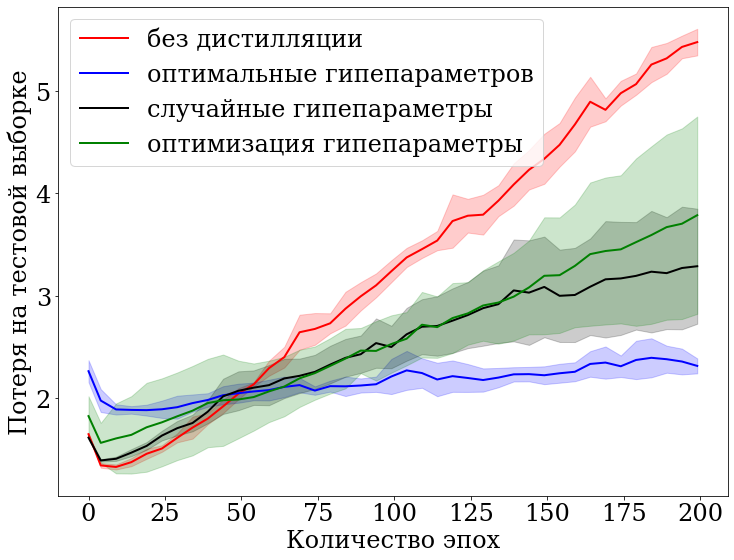

In [100]:
from matplotlib import pylab as plt
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 24

epoch_b = np.array([data_b[2]['results'][i]['epoch'] for i in range(len(data_b[0]['results']))])
loss_b = np.array([subdata['results'][i]['test loss'] for i in range(len(data_b[0]['results'])) for subdata in data_b]).reshape(epoch_b.shape[0], -1)
plt.plot(epoch_b, loss_b.mean(1), '-', color='red', label='без дистилляции')
plt.fill_between(epoch_b, loss_b.mean(1)-loss_b.std(1), loss_b.mean(1)+loss_b.std(1), alpha=0.2, color='red')

epoch_d = np.array([data_d[2]['results'][i]['epoch'] for i in range(len(data_d[2]['results']))])
loss_d = np.array([subdata['results'][i]['test loss'] for i in range(len(data_d[0]['results'])) for subdata in data_d]).reshape(epoch_d.shape[0], -1)
plt.plot(epoch_d, loss_d.mean(1), '-', color='blue', label='оптимальные гипепараметров')
plt.fill_between(epoch_d, loss_d.mean(1)-loss_d.std(1), loss_d.mean(1)+loss_d.std(1), alpha=0.2, color='blue')

epoch_dr = np.array([data_dr[2]['results'][i]['epoch'] for i in range(len(data_dr[2]['results']))])
loss_dr = np.array([subdata['results'][i]['test loss'] for i in range(len(data_dr[0]['results'])) for subdata in data_dr]).reshape(epoch_dr.shape[0], -1)
plt.plot(epoch_dr, loss_dr.mean(1), '-', color='black', label='случайные гипепараметры')
plt.fill_between(epoch_dr, loss_dr.mean(1)-loss_dr.std(1), loss_dr.mean(1)+loss_dr.std(1), alpha=0.2, color='black')


epoch_h = np.array([data_dr[2]['results'][i]['epoch'] for i in range(len(data_h[2]['results']))])
loss_h = np.array([subdata['results'][i]['test loss'] for i in range(len(data_d[0]['results'])) for subdata in data_h]).reshape(epoch_h.shape[0], -1)
plt.plot(epoch_h, loss_h.mean(1), '-', color='green', label='оптимизация гипепараметры')
plt.fill_between(epoch_h, loss_h.mean(1)-loss_h.std(1), loss_h.mean(1)+loss_h.std(1), alpha=0.2, color='green')

plt.xlabel('Количество эпох')
plt.ylabel('Потеря на тестовой выборке')

plt.legend()
plt.savefig('loss_10.pdf')

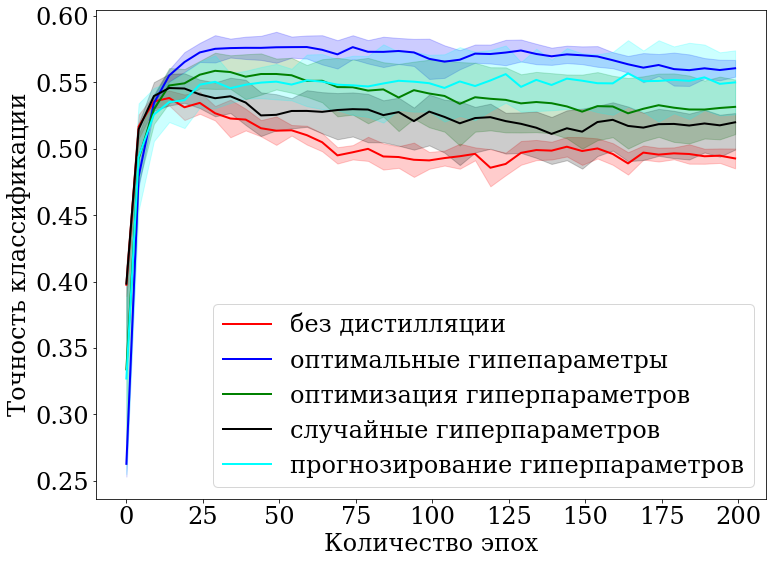

In [101]:
epoch_b = np.array([data_b[2]['results'][i]['epoch'] for i in range(len(data_b[0]['results']))])
acc_b = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_b[0]['results'])) for subdata in data_b]).reshape(epoch_b.shape[0], -1)
plt.plot(epoch_b, acc_b.mean(1), '-', color='red', label='без дистилляции')
plt.fill_between(epoch_b, acc_b.mean(1)-acc_b.std(1), acc_b.mean(1)+acc_b.std(1), alpha=0.2, color='red')

epoch_d = np.array([data_d[2]['results'][i]['epoch'] for i in range(len(data_d[2]['results']))])
acc_d = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_d[0]['results'])) for subdata in data_d]).reshape(epoch_d.shape[0], -1)
plt.plot(epoch_d, acc_d.mean(1), '-', color='blue', label='оптимальные гипепараметры')
plt.fill_between(epoch_d, acc_d.mean(1)-acc_d.std(1), acc_d.mean(1)+acc_d.std(1), alpha=0.2, color='blue')

epoch_h = np.array([data_h[2]['results'][i]['epoch'] for i in range(len(data_h[2]['results']))])
acc_h = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_d[0]['results'])) for subdata in data_h]).reshape(epoch_h.shape[0], -1)
plt.plot(epoch_h, acc_h.mean(1), '-', color='green', label='оптимизация гиперпараметров')
plt.fill_between(epoch_h, acc_h.mean(1)-acc_h.std(1), acc_h.mean(1)+acc_h.std(1), alpha=0.2, color='green')

epoch_dr = np.array([data_dr[2]['results'][i]['epoch'] for i in range(len(data_dr[2]['results']))])
acc_dr = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_dr[0]['results'])) for subdata in data_dr]).reshape(epoch_h.shape[0], -1)
plt.plot(epoch_dr, acc_dr.mean(1), '-', color='black', label='случайные гиперпараметров')
plt.fill_between(epoch_dr, acc_dr.mean(1)-acc_h.std(1), acc_dr.mean(1)+acc_dr.std(1), alpha=0.2, color='black')

epoch_s = np.array([data_s[2]['results'][i]['epoch'] for i in range(len(data_s[2]['results']))])
acc_s = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_s[0]['results'])) for subdata in data_s]).reshape(epoch_s.shape[0], -1)
plt.plot(epoch_s, acc_s.mean(1), '-', color='cyan', label='прогнозирование гиперпараметров')
plt.fill_between(epoch_s, acc_s.mean(1)-acc_s.std(1), acc_s.mean(1)+acc_s.std(1), alpha=0.2, color='cyan')


plt.xlabel('Количество эпох')
plt.ylabel('Точность классификации')
plt.legend()
plt.savefig('acc_10.pdf')

-----------------

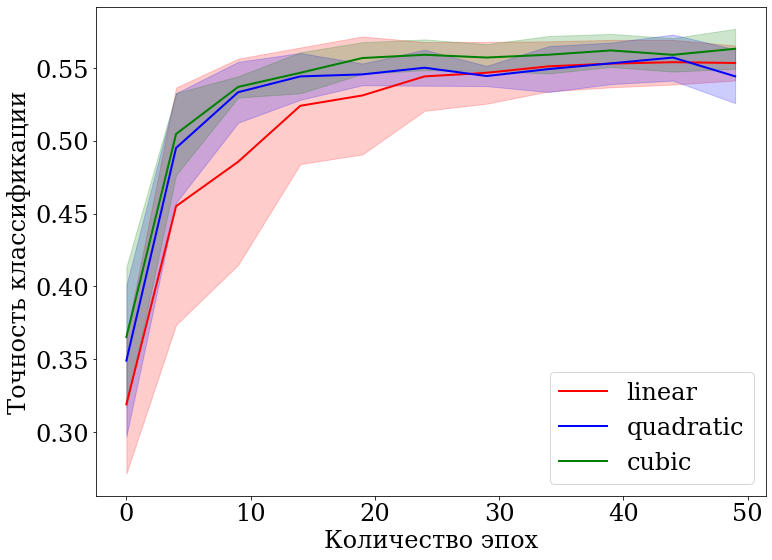

In [53]:
with open("exp8_dist_h_b2_optim.jsonl", "r") as read_file:
    data_l = [json.loads(line) for line in read_file]
with open("exp9_dist_h_b2_optim.jsonl", "r") as read_file:
    data_q = [json.loads(line) for line in read_file]
with open("exp10_dist_h_b2_optim.jsonl", "r") as read_file:
    data_c = [json.loads(line) for line in read_file]

epoch_l = np.array([data_l[2]['results'][i]['epoch'] for i in range(len(data_l[2]['results']))])
acc_l = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_l[0]['results'])) for subdata in data_l]).reshape(epoch_l.shape[0], -1)
plt.plot(epoch_l[0:11], acc_l[0:11].mean(1), '-', color='red', label='linear')
plt.fill_between(epoch_l[0:11], acc_l[0:11].mean(1)-acc_l[0:11].std(1), acc_l[0:11].mean(1)+acc_l[0:11].std(1), alpha=0.2, color='red')

epoch_q = np.array([data_s[2]['results'][i]['epoch'] for i in range(len(data_q[2]['results']))])
acc_q = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_q[0]['results'])) for subdata in data_q]).reshape(epoch_q.shape[0], -1)
plt.plot(epoch_q, acc_q.mean(1), '-', color='blue', label='quadratic')
plt.fill_between(epoch_q, acc_q.mean(1)-acc_q.std(1), acc_q.mean(1)+acc_q.std(1), alpha=0.2, color='blue')

epoch_c = np.array([data_c[2]['results'][i]['epoch'] for i in range(len(data_c[2]['results']))])
acc_c = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_c[0]['results'])) for subdata in data_c]).reshape(epoch_c.shape[0], -1)
plt.plot(epoch_c, acc_c.mean(1), '-', color='green', label='cubic')
plt.fill_between(epoch_c, acc_c.mean(1)-acc_c.std(1), acc_c.mean(1)+acc_c.std(1), alpha=0.2, color='green')

plt.xlabel('Количество эпох')
plt.ylabel('Точность классификации')
plt.legend()
plt.savefig('acc_splines.pdf')

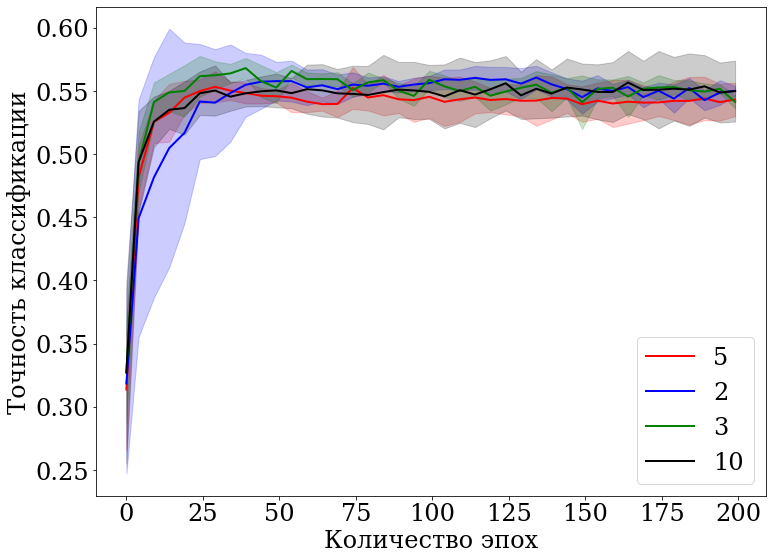

In [103]:
with open("exp11_dist_h_b2_optim.jsonl", "r") as read_file:
    data_5 = [json.loads(line) for line in read_file]
with open("exp12_dist_h_b2_optim.jsonl", "r") as read_file:
    data_2 = [json.loads(line) for line in read_file]
with open("exp13_dist_h_b2_optim.jsonl", "r") as read_file:
    data_3 = [json.loads(line) for line in read_file]
with open("exp14_dist_h_b2_optim.jsonl", "r") as read_file:
    data_10 = [json.loads(line) for line in read_file]

def plot_data(data, label, color):
    epoch = np.array([data[2]['results'][i]['epoch'] for i in range(len(data[2]['results']))])
    acc = np.array([subdata['results'][i]['accuracy'] for i in range(len(data[0]['results'])) for subdata in data]).reshape(epoch.shape[0], -1)
    plt.plot(epoch, acc.mean(1), '-', color=color, label=label)
    plt.fill_between(epoch, acc.mean(1)-acc.std(1), acc.mean(1)+acc.std(1), alpha=0.2, color=color)
    
# epoch_2 = np.array([data_2[2]['results'][i]['epoch'] for i in range(len(data_2[2]['results']))])
# acc_2 = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_l[0]['results'])) for subdata in data_l]).reshape(epoch_l.shape[0], -1)
# plt.plot(epoch_l[0:11], acc_l[0:11].mean(1), '-', color='red', label='linear')
# plt.fill_between(epoch_l[0:11], acc_l[0:11].mean(1)-acc_l[0:11].std(1), acc_l[0:11].mean(1)+acc_l[0:11].std(1), alpha=0.2, color='red')

# epoch_q = np.array([data_s[2]['results'][i]['epoch'] for i in range(len(data_q[2]['results']))])
# acc_q = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_q[0]['results'])) for subdata in data_q]).reshape(epoch_q.shape[0], -1)
# plt.plot(epoch_q, acc_q.mean(1), '-', color='blue', label='quadratic')
# plt.fill_between(epoch_q, acc_q.mean(1)-acc_q.std(1), acc_q.mean(1)+acc_q.std(1), alpha=0.2, color='blue')

# epoch_c = np.array([data_c[2]['results'][i]['epoch'] for i in range(len(data_c[2]['results']))])
# acc_c = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_c[0]['results'])) for subdata in data_c]).reshape(epoch_c.shape[0], -1)
# plt.plot(epoch_c, acc_c.mean(1), '-', color='green', label='cubic')
# plt.fill_between(epoch_c, acc_c.mean(1)-acc_c.std(1), acc_c.mean(1)+acc_c.std(1), alpha=0.2, color='green')
plot_data(data_5, '5', 'red')
plot_data(data_2, '2', 'blue')
plot_data(data_3, '3', 'green')
plot_data(data_10, '10', 'black')

plt.xlabel('Количество эпох')
plt.ylabel('Точность классификации')
plt.legend()
plt.savefig('acc_splines.pdf')